# Black Box Analyzer v0.1 beta

<https://github.com/yannpom/blackbox-tools>

## Make this tool yours:

Do not hesitate to play with the data, add plots, add comments, and suggest improvements. The goal of a Jupyter notebook is that it's very easy for everyone to modify.

## Table of content:

* [Spectral analysis](#Spectral-analysis)
  * Filtered Gyro
  * Unfiltered Gyro (GYRO_SCALED)
  * PID D
* [Flips & Rolls](#Flips-&-Rolls-Response)
  * Find all the flips & rolls and plot them individually
* [Step Response](#Step-Response)
  * Compute and plot the gyro response to a setpoint step

# Upload your Blackbox file

Open the "File browser" left pannel and drag&drop your `*.bbl` file.

The next cell will import stuff, and try to load the first `*.bbl` it finds.

If you don't have a blackbox file, a sample one will be provided: just run the cell!

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.signal
import scipy.fft
from blackbox import BlackBoxFile
import glob
import math

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18,10)

AXIS = ['[0]', '[1]', '[2]']
AXIS_LABEL = ['ROLL', 'PITCH', 'YAW']


files = glob.glob("*.bbl")
BLACKBOX_FILE = files[0] if files else "blackbox_samples/btfl_all.bbl"
print(f"Using file: {BLACKBOX_FILE}")

blackBoxFile = BlackBoxFile(BLACKBOX_FILE)
flights = blackBoxFile.flights

for flight in blackBoxFile.flights:
    print(flight)

freqs = [flight.freq for flight in flights]
FS = np.mean(freqs)
print()
print(f"{len(flights)} flights loaded. Average sampling frequency: {FS:.1f} Hz")
if np.min(freqs) < 0.9*FS or np.max(freqs) > 1.1*FS:
    raise ValueError("All file must have the same sampling frequency")

Using file: btfl_001.bbl
Flight 0, 168 seconds, 139254 samples @ 811.7 Hz
Flight 1, 64 seconds, 52816 samples @ 801.3 Hz
Flight 2, 65 seconds, 53406 samples @ 822.4 Hz

3 flights loaded. Average sampling frequency: 811.8 Hz


# Spectral analysis

Gyro raw + filtered + D term noise analysis.

Excessive noise on the D term will lead to overheating of burning motors/ESC. When you increase the D gain, all the gyro noise will be amplified. I think the PID D term's FFT is a good indicator of the margin you have in increasing or not the D gain.

Method:
- Compute hundreds of FFT with a sliding window moving over the data
- For each frequency, keep the maximum of all the FFT computed.
- Plot the result, which is the PEAK amplitude for each frequency.

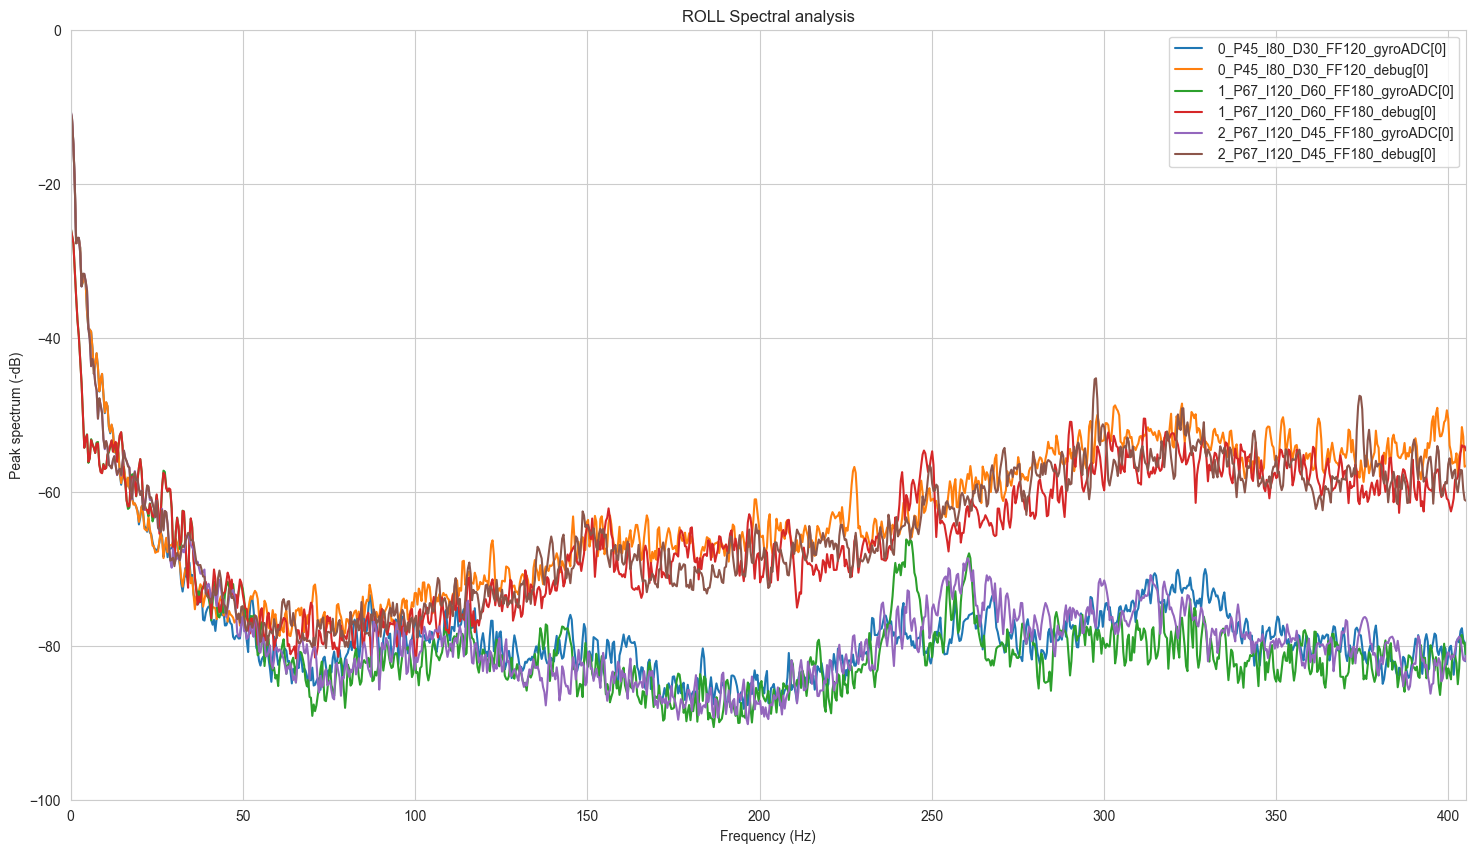

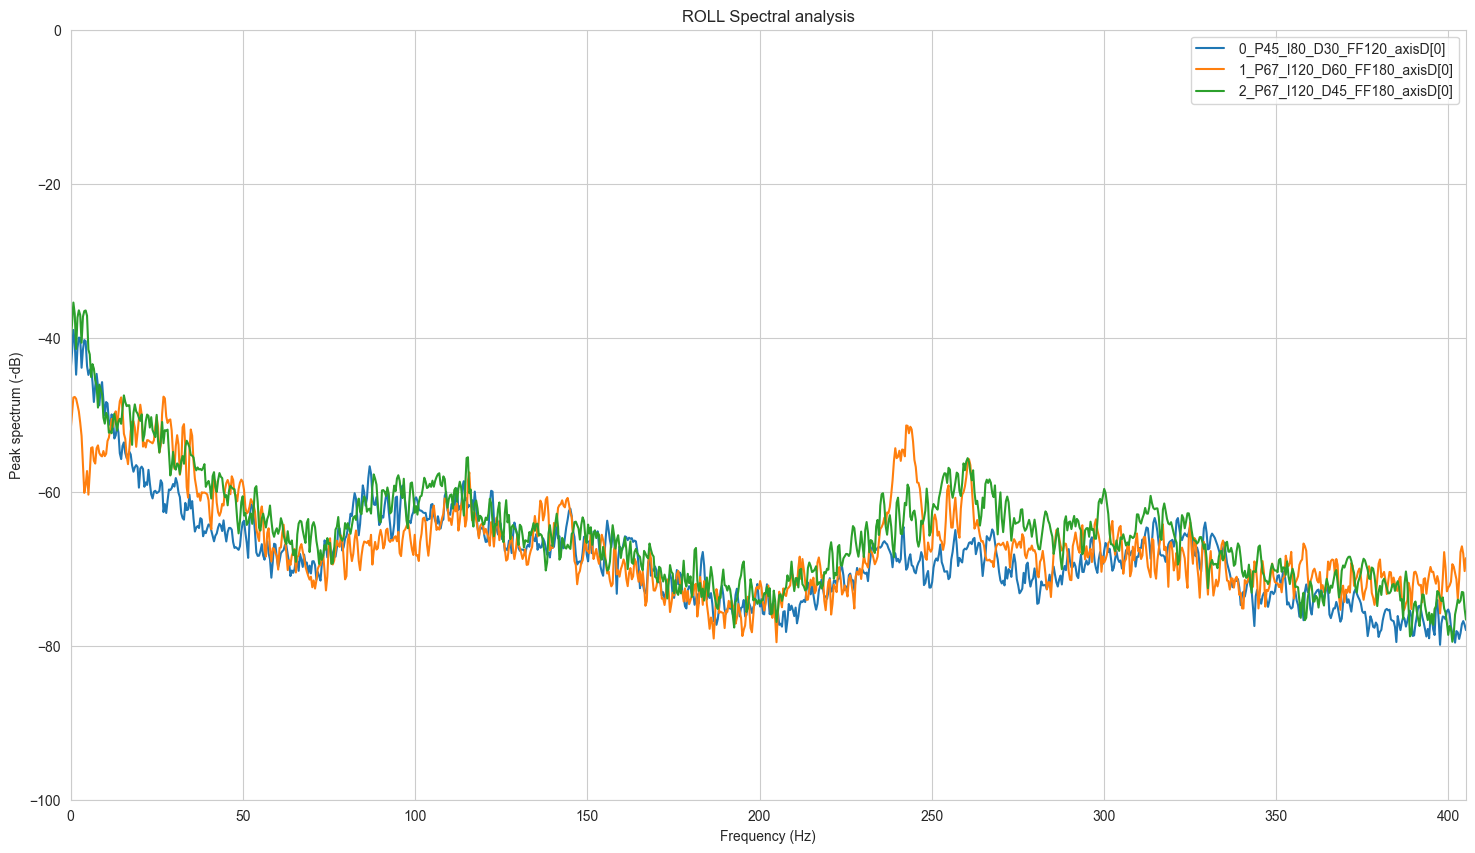

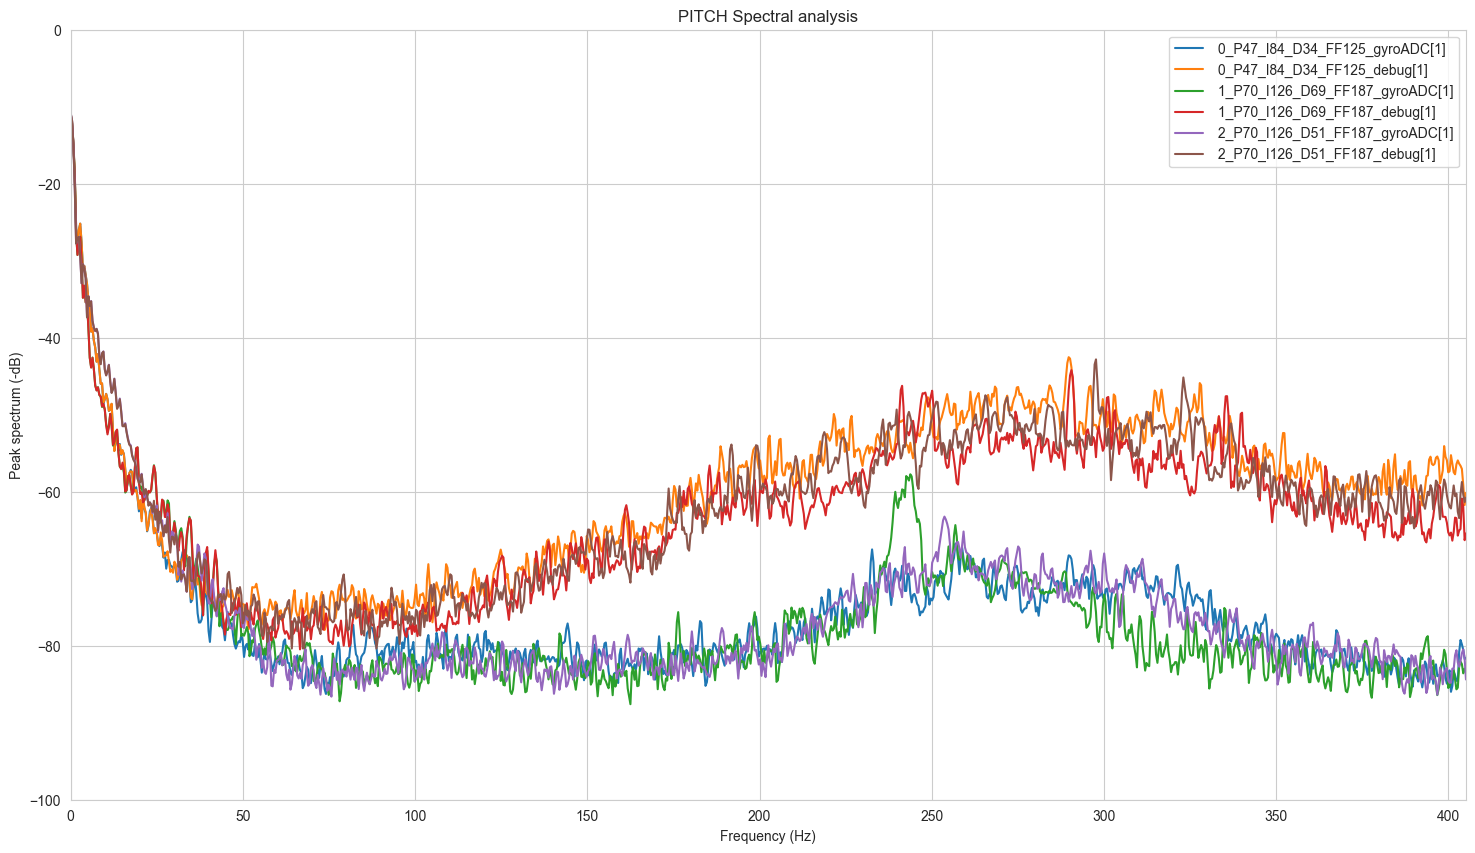

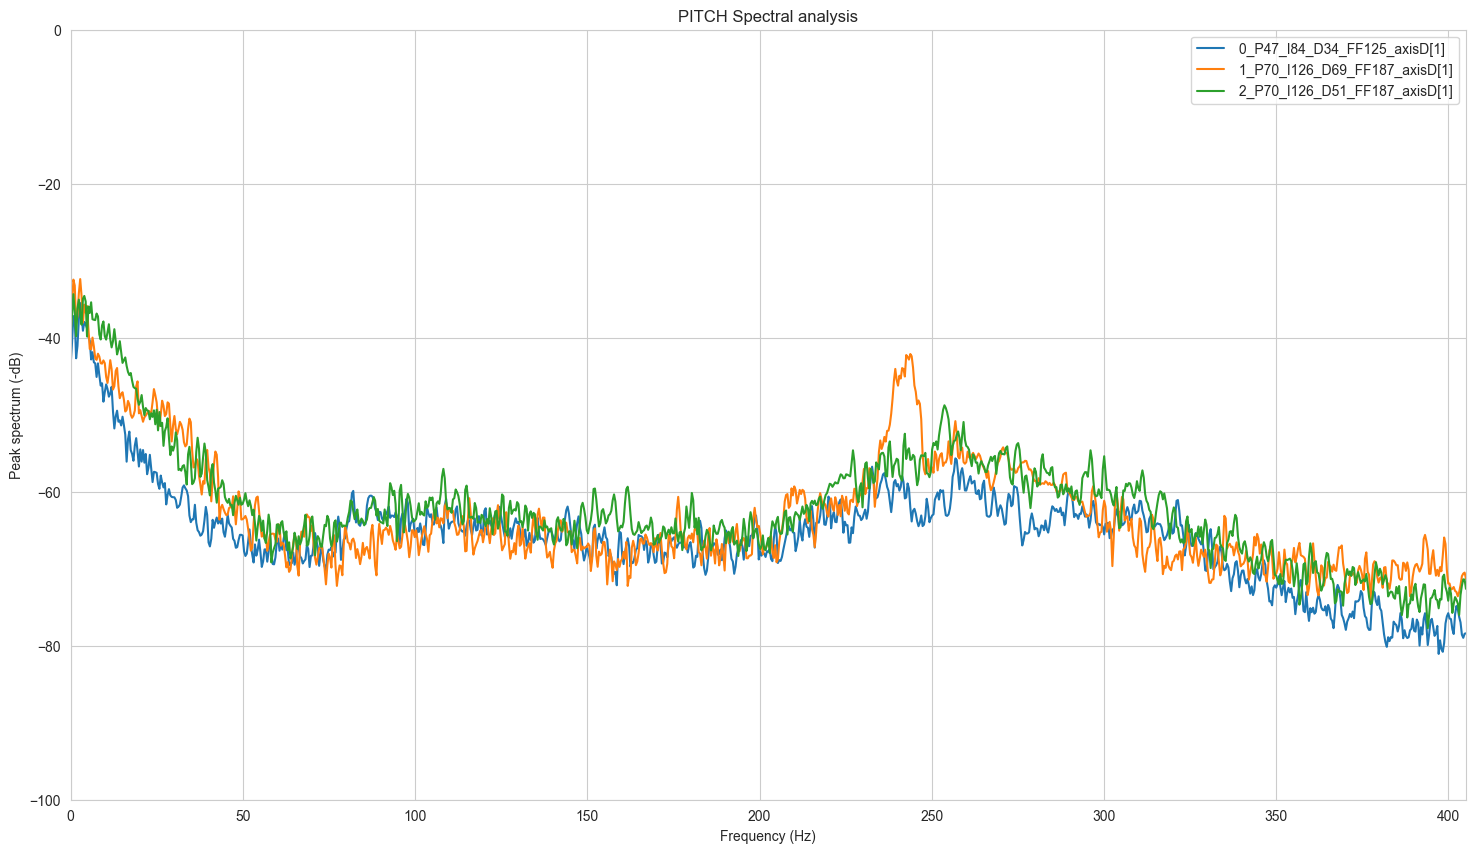

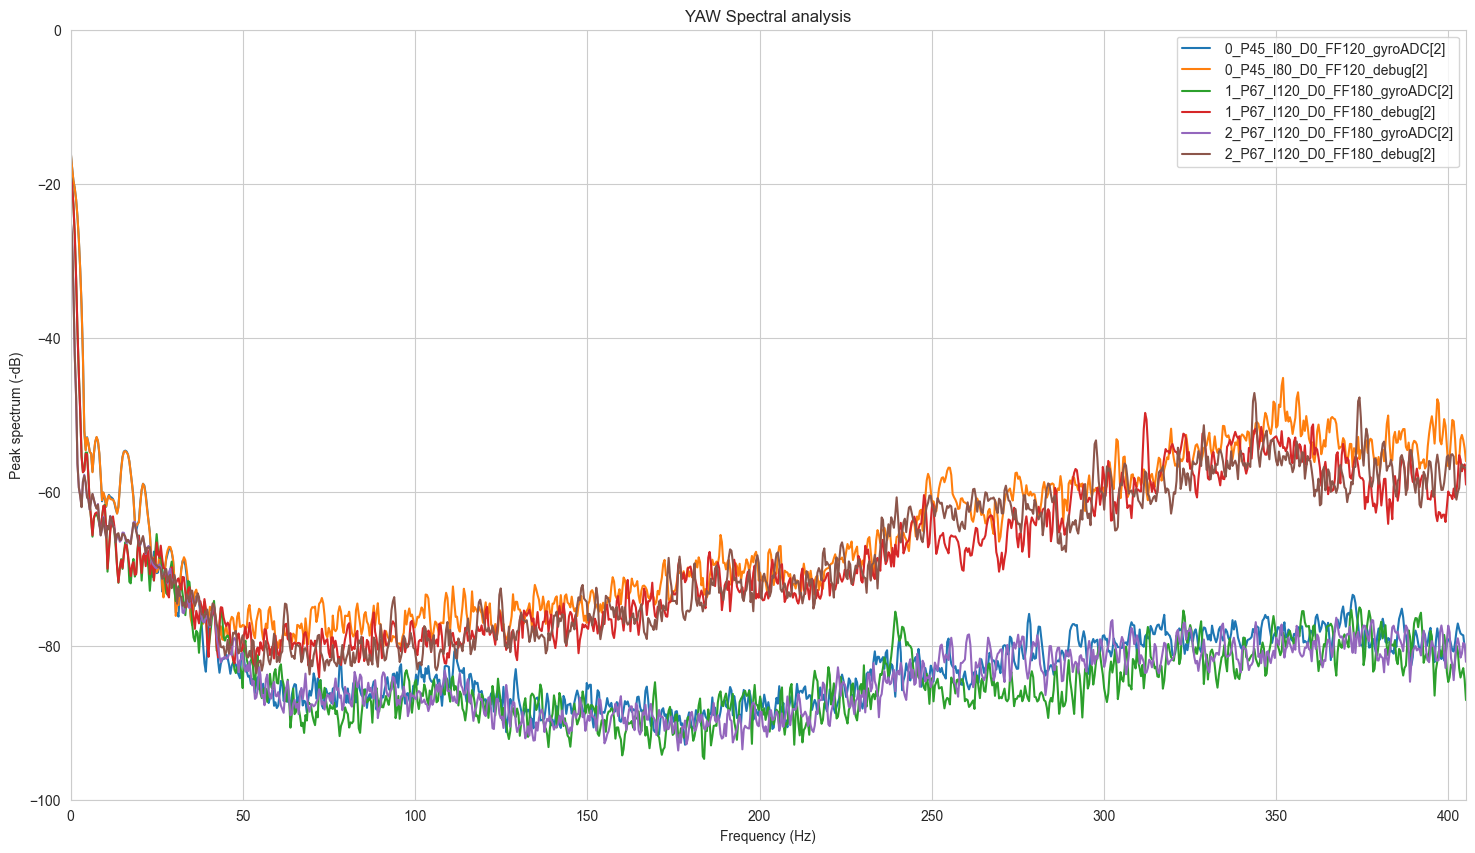

In [2]:
def compute_noise(df, fields, FS, N_FFT=2048):
    def max_fft_with_moving_window(y, max_range=1.0):
        STEP = N_FFT // 8
        n_chunks = len(y) // N_FFT
        steps = len(y) // STEP
        p = np.zeros(N_FFT//2+1)
        # Loop through the data to find the max FFT amplitude
        for step in range(steps):
            pos = step * STEP
            chunk = y[pos:pos+N_FFT].copy()
            chunk.resize(N_FFT)
            chunk *= scipy.signal.blackman(N_FFT)
            yf = scipy.fft.rfft(chunk, n=N_FFT, norm="forward")
            freq = scipy.fft.rfftfreq(N_FFT, d=1/FS)
            yf = np.abs(yf)
            p = np.maximum(p, yf)

        # Normalize so that a max amplitude sine is at 0 dB
        p = 4*p
        
        p /= max_range
        p = 20 * np.log10(p)
        return freq, p

    data = {}
    for field in fields:
        if field == 'debug[3]':
            continue
        max_range = 1.0
        if field.startswith(("debug", "gyro")):
            # used to scale the plot so that the max value is 0dB
            max_range = math.radians(2000) # Full gyro range is 2000deg/s
        f, p = max_fft_with_moving_window(df[field].to_numpy(), max_range)
        data[field] = p

    return pd.DataFrame(data, f)

def compute_noise_per_flight(*columns_to_plot):
    noise_per_flight = []
    for i, flight in enumerate(flights):
        for axis in range(3):
            # Filter columns to plot
            fields = [name for name in flight.data.columns.values if name.startswith(columns_to_plot) and name.endswith(AXIS[axis])]
            if not fields: # no PID D on YAW
                continue
            noise = compute_noise(flight.data, fields, FS)
            # Prefix with file/flight
            rename = {name: f"{flight.prefix(axis)}{name}" for name in noise.columns}
            noise = noise.rename(columns=rename)
            noise_per_flight.append(noise)

    noise_per_flight = pd.concat(noise_per_flight, axis=1)
    return noise_per_flight

def plot_spectrum(data, axis):
    columns = [c for c in data.columns if c.endswith(AXIS[axis])]
    if not columns: # no PID D on YAW
        return
    sns.lineplot(data=data[columns], dashes=False, palette="tab10")
    plt.ylim([-100, 0])
    plt.xlim([0, FS//2])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(f"Peak spectrum (-dB)")
    plt.title(f'{AXIS_LABEL[axis]} Spectral analysis')
    
    
# Peak FFT with sliding window
gyro_noise = compute_noise_per_flight("gyro", "debug")
d_term_noise = compute_noise_per_flight("axisD")

for axis in range(3):
    plot_spectrum(gyro_noise, axis=axis)
    plt.show()
    plot_spectrum(d_term_noise, axis=axis)
    plt.show()

# Flips & Rolls Response

Process:
- Find part of data where each axis `setpoint` is above `THREASHOLD_UPPER` (default is 400 degrees/s).
- Check that the integration of `setpoint` over the detected area roughly matches a 360 degrees flip (+/- 60 deg)
- Add `LOOP_EXTRA_TIME` (0.3 second) of buffer on each side of the flip.
- For each detected roll of flip, plot the PID `P`, `I`, `D`, `FF`, `Setpoint` and `Gyro`.

Note:
`DISPLAY_WITH_LOW_PASS_FILTER = True` smooths the plotting of `P`, `D` and `Gyro`.

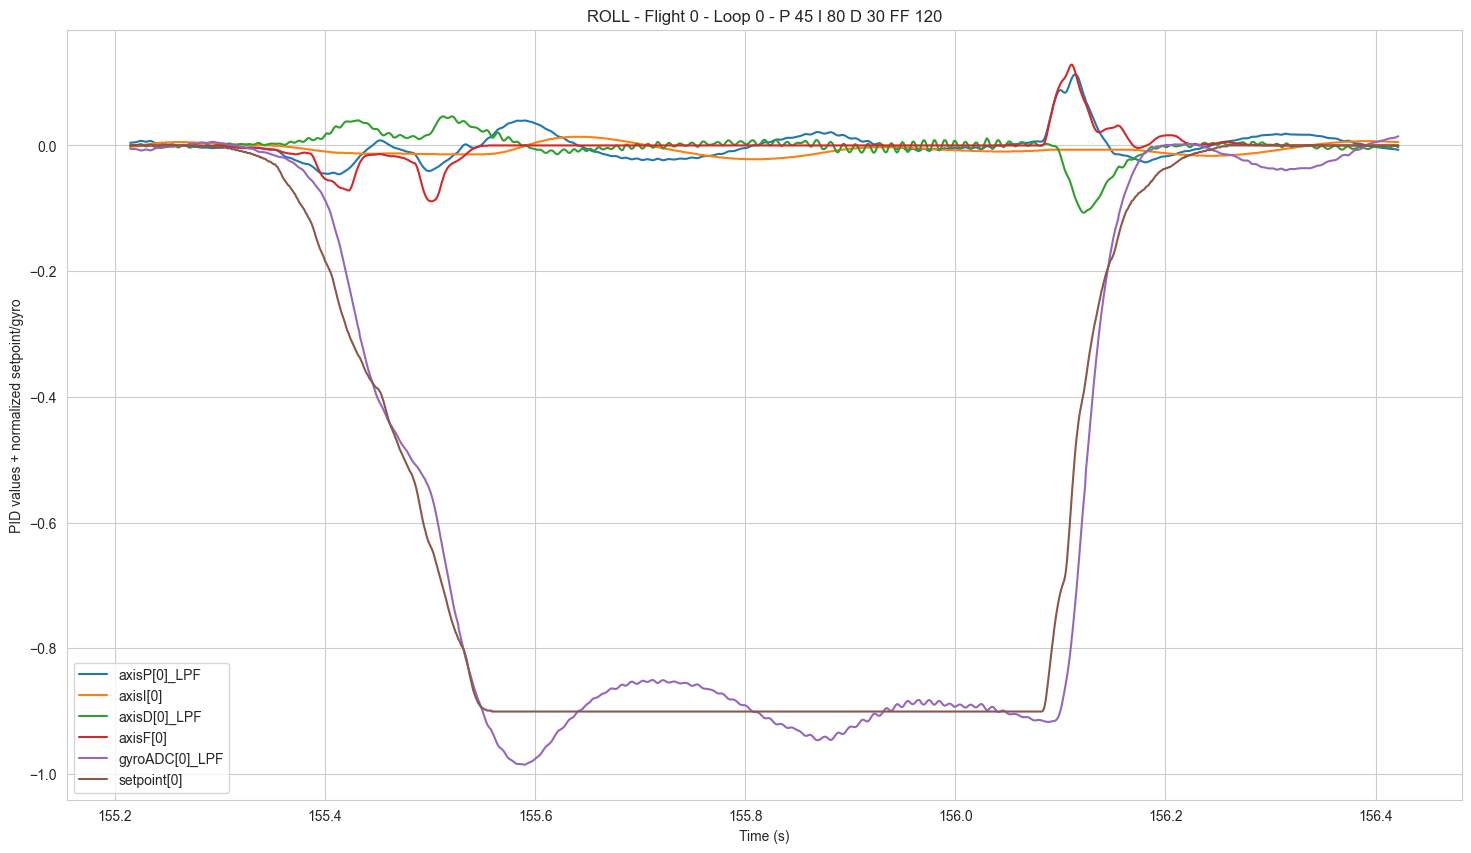

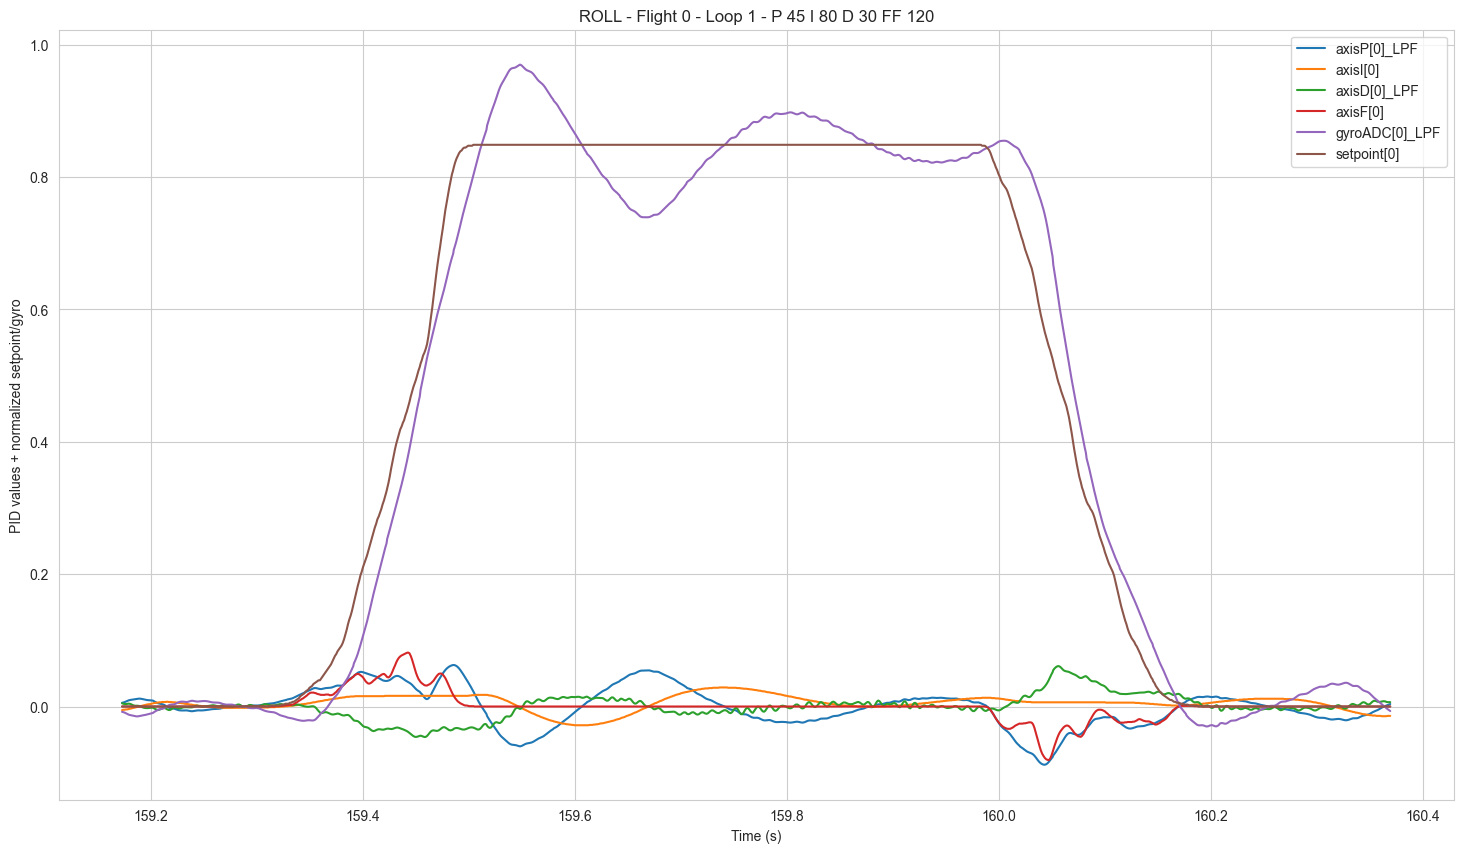

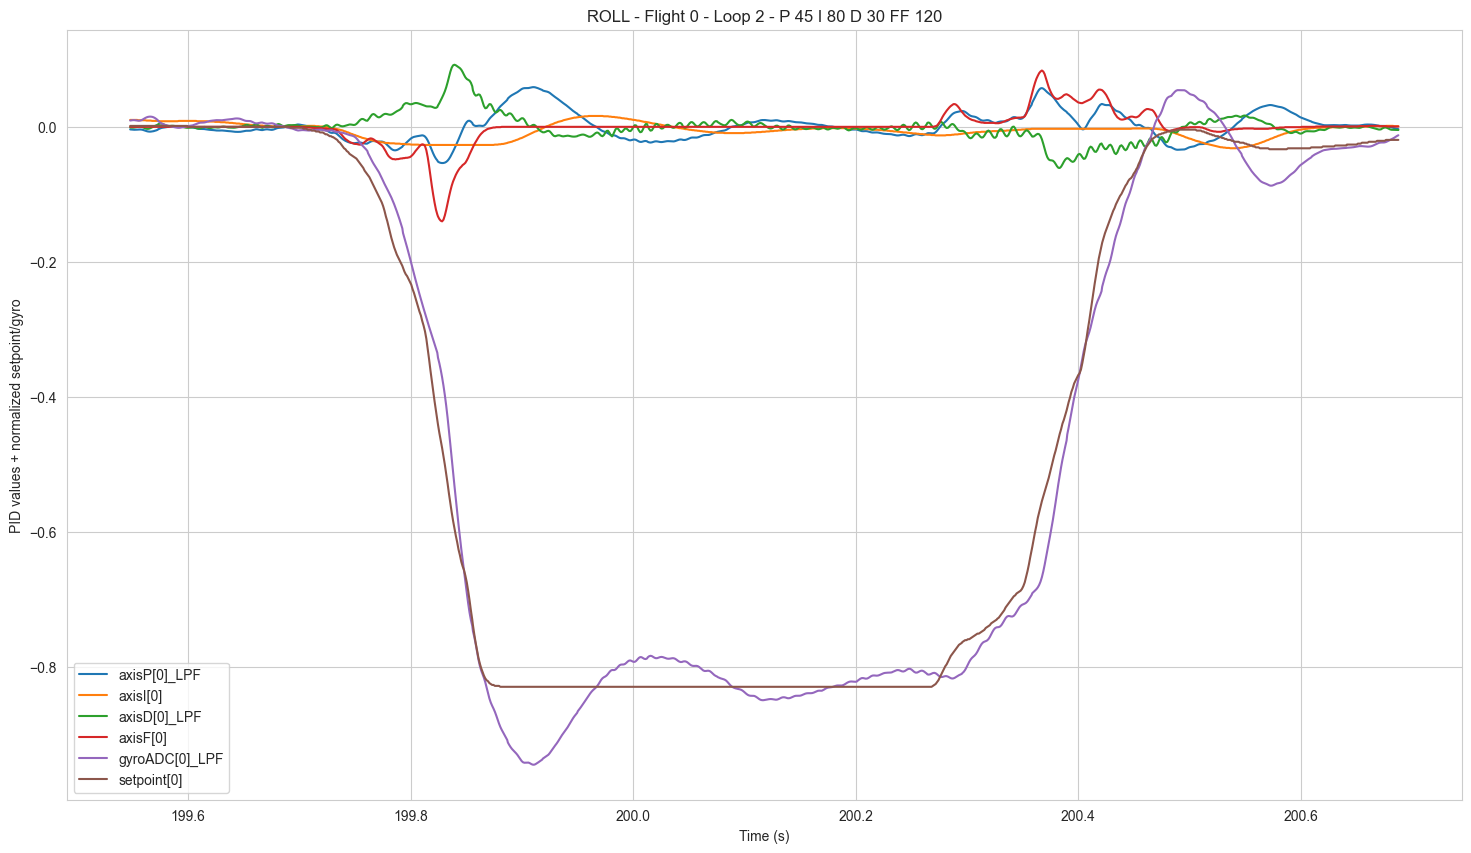

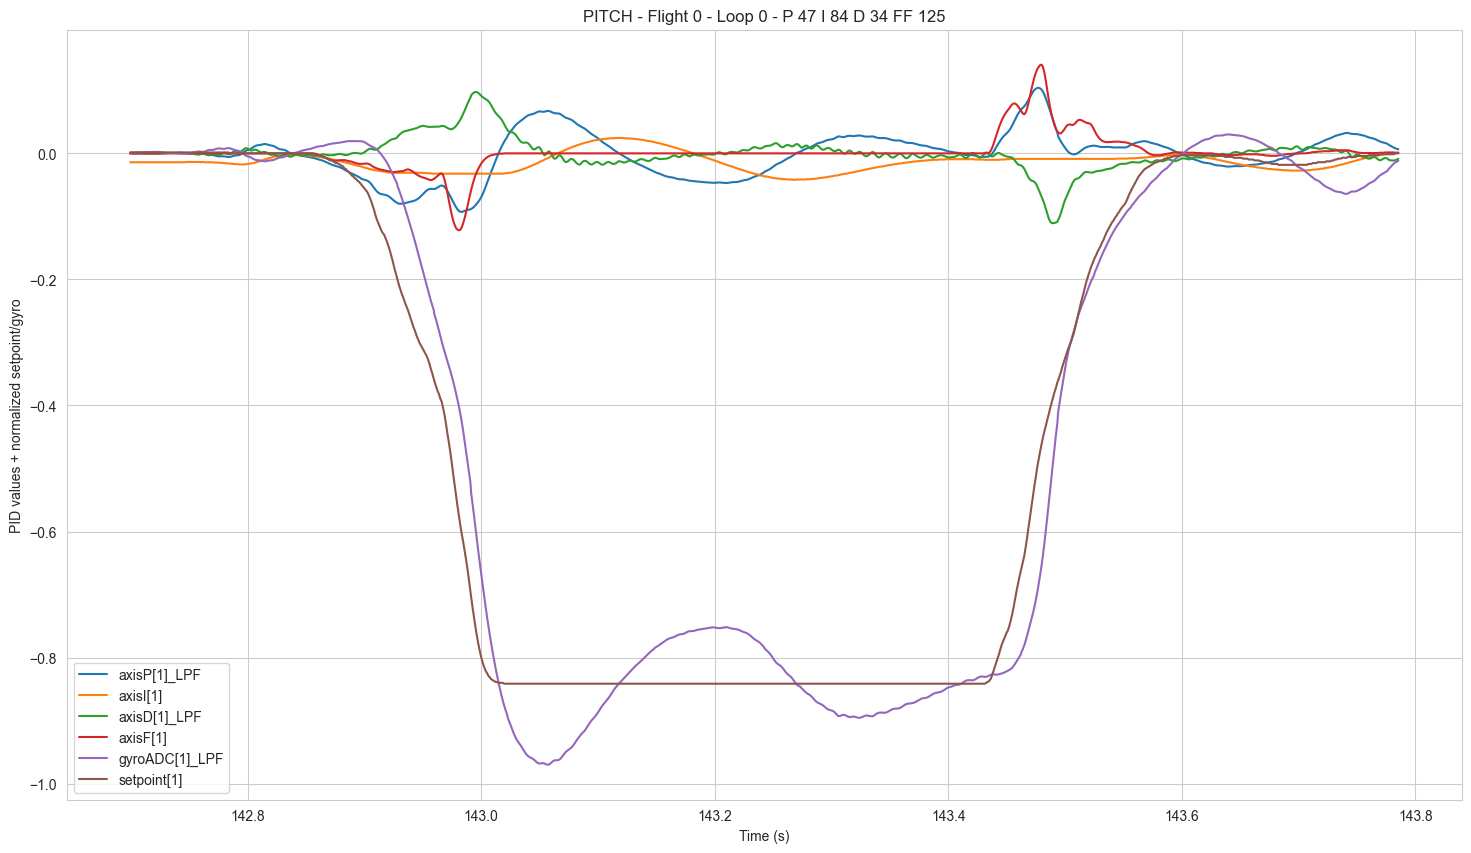

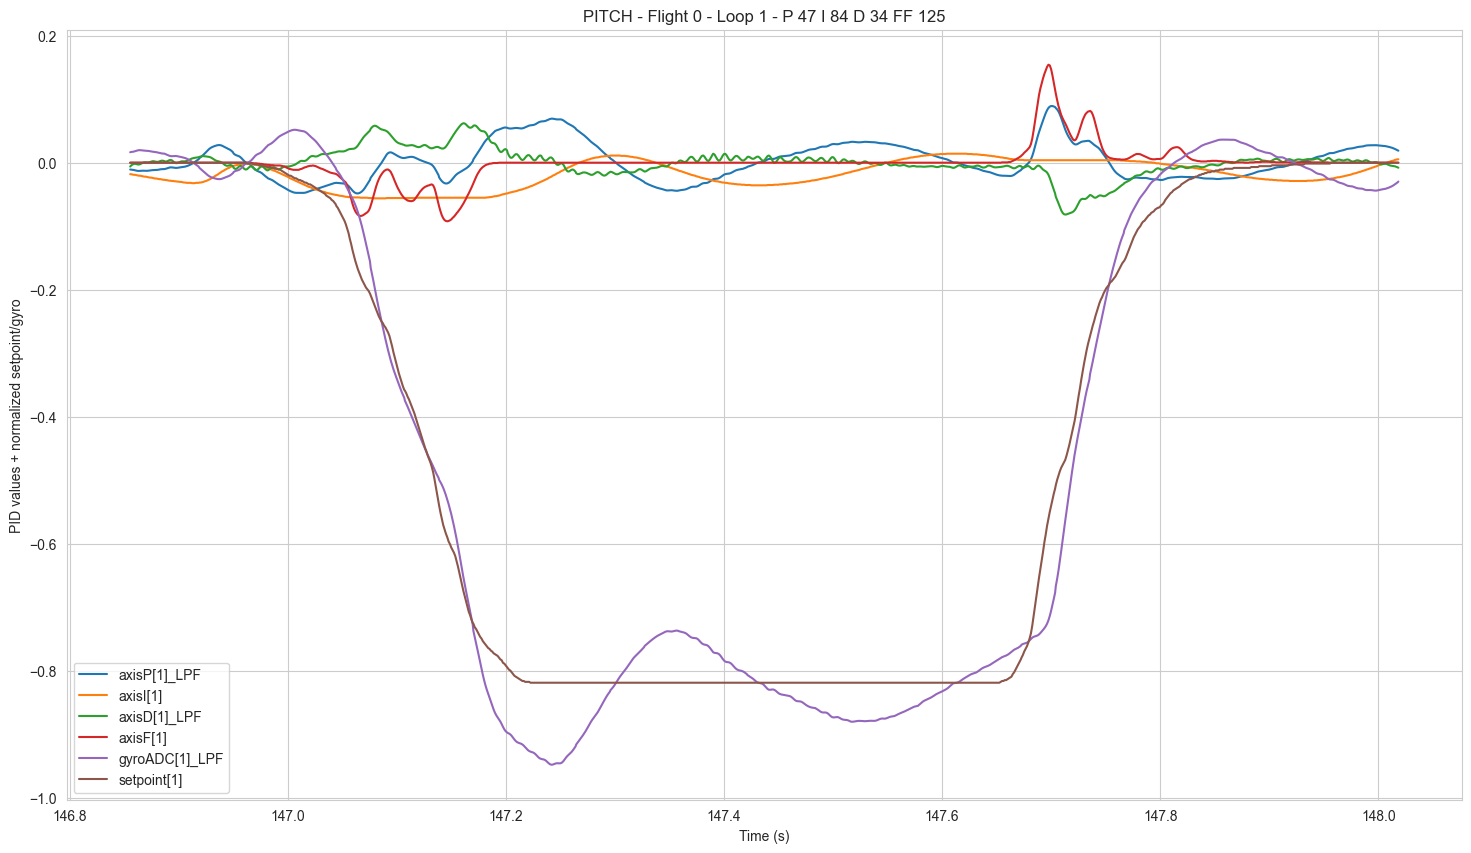

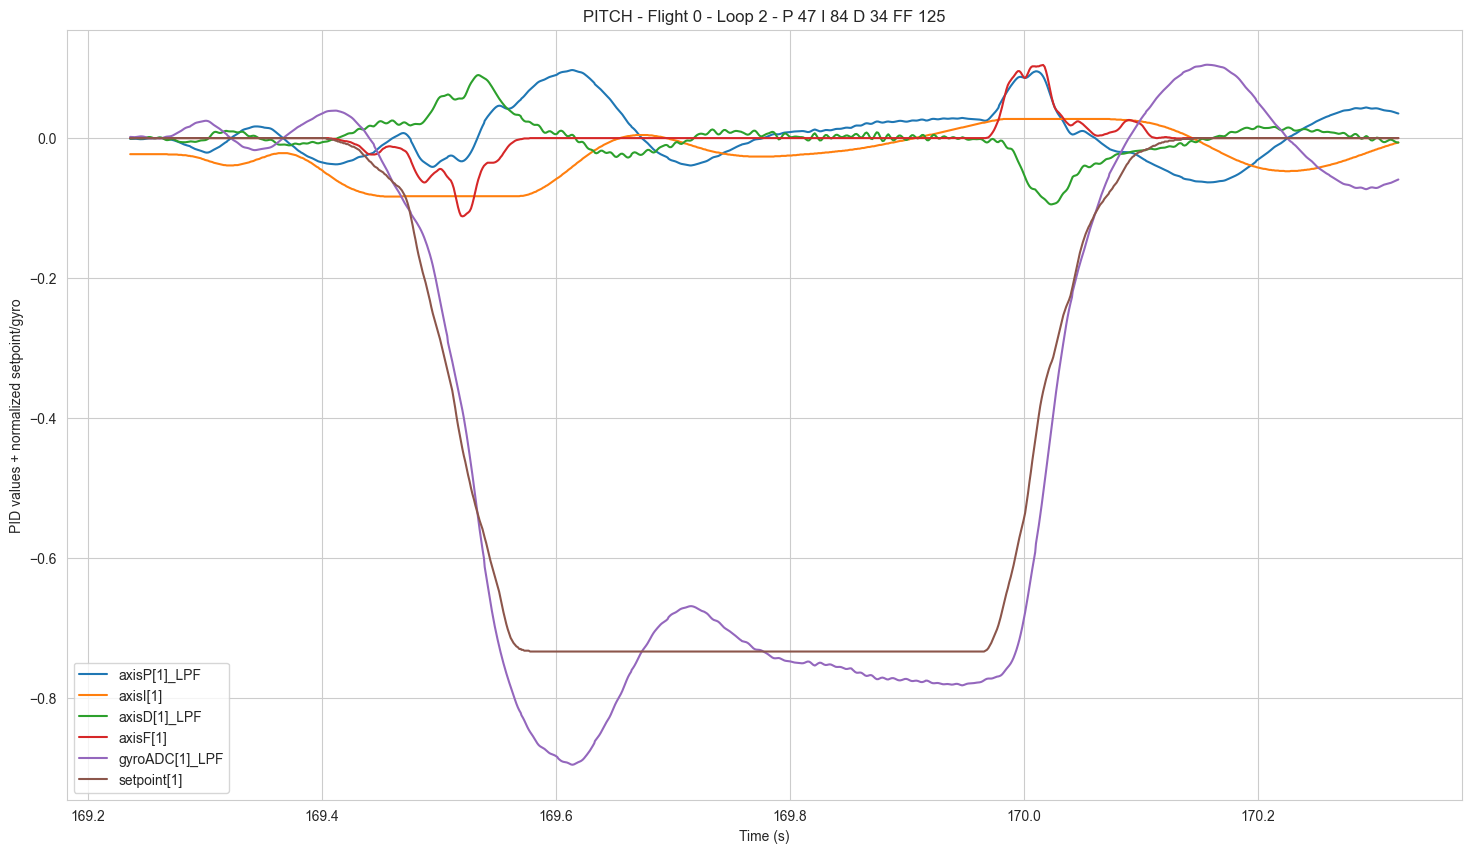

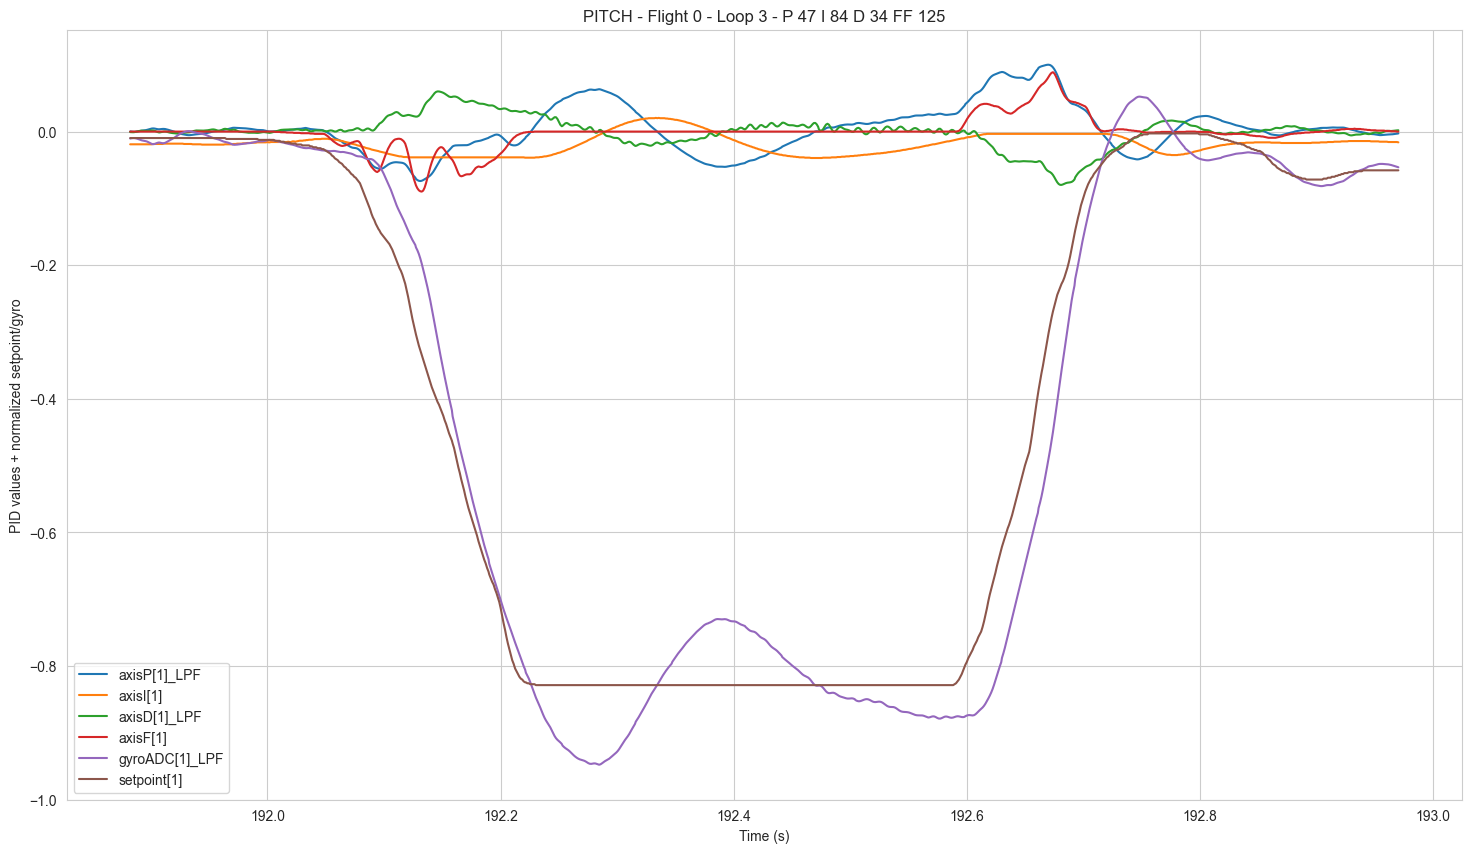

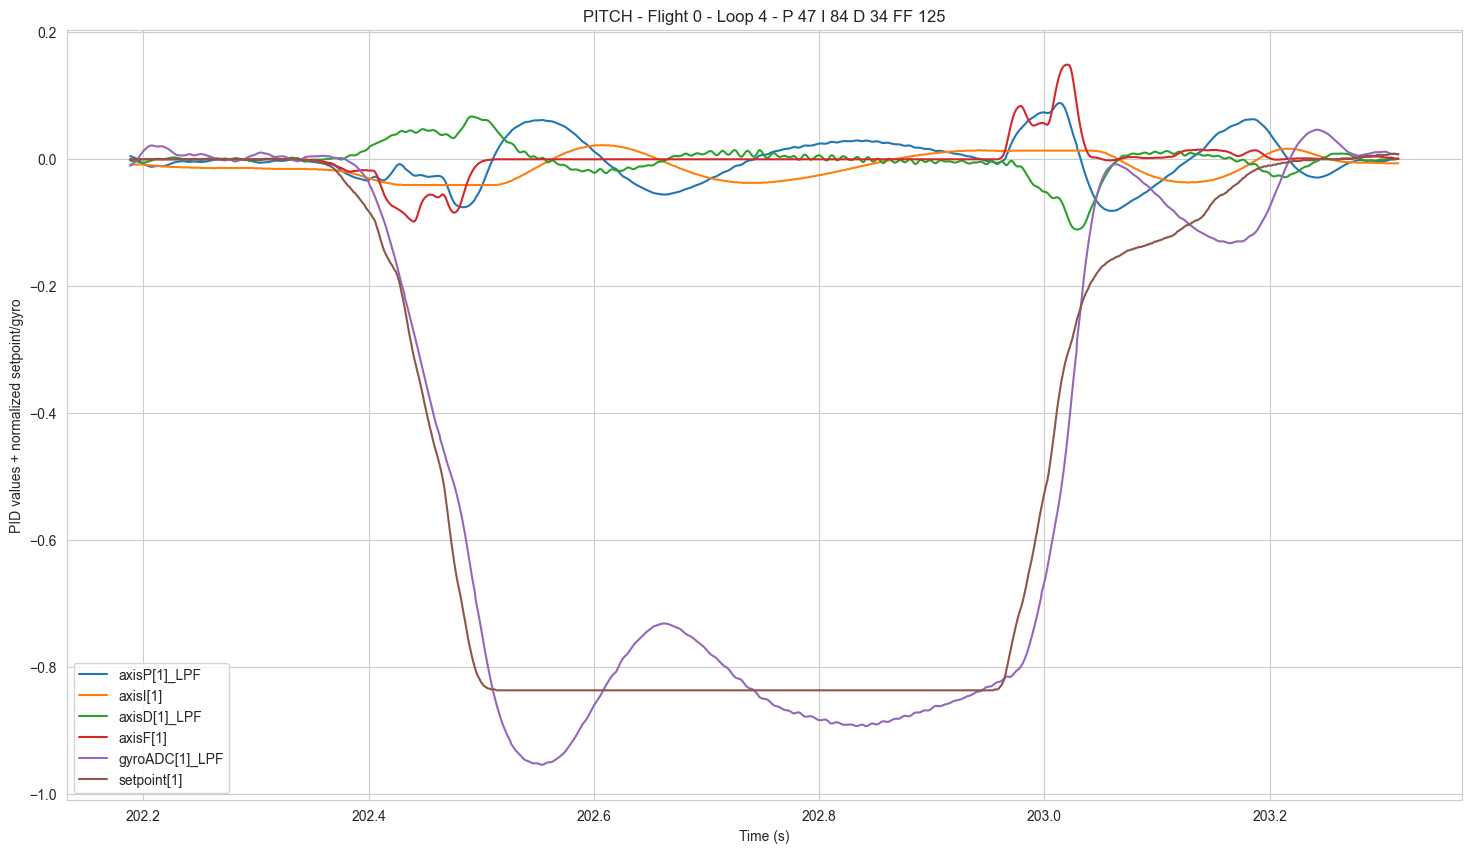

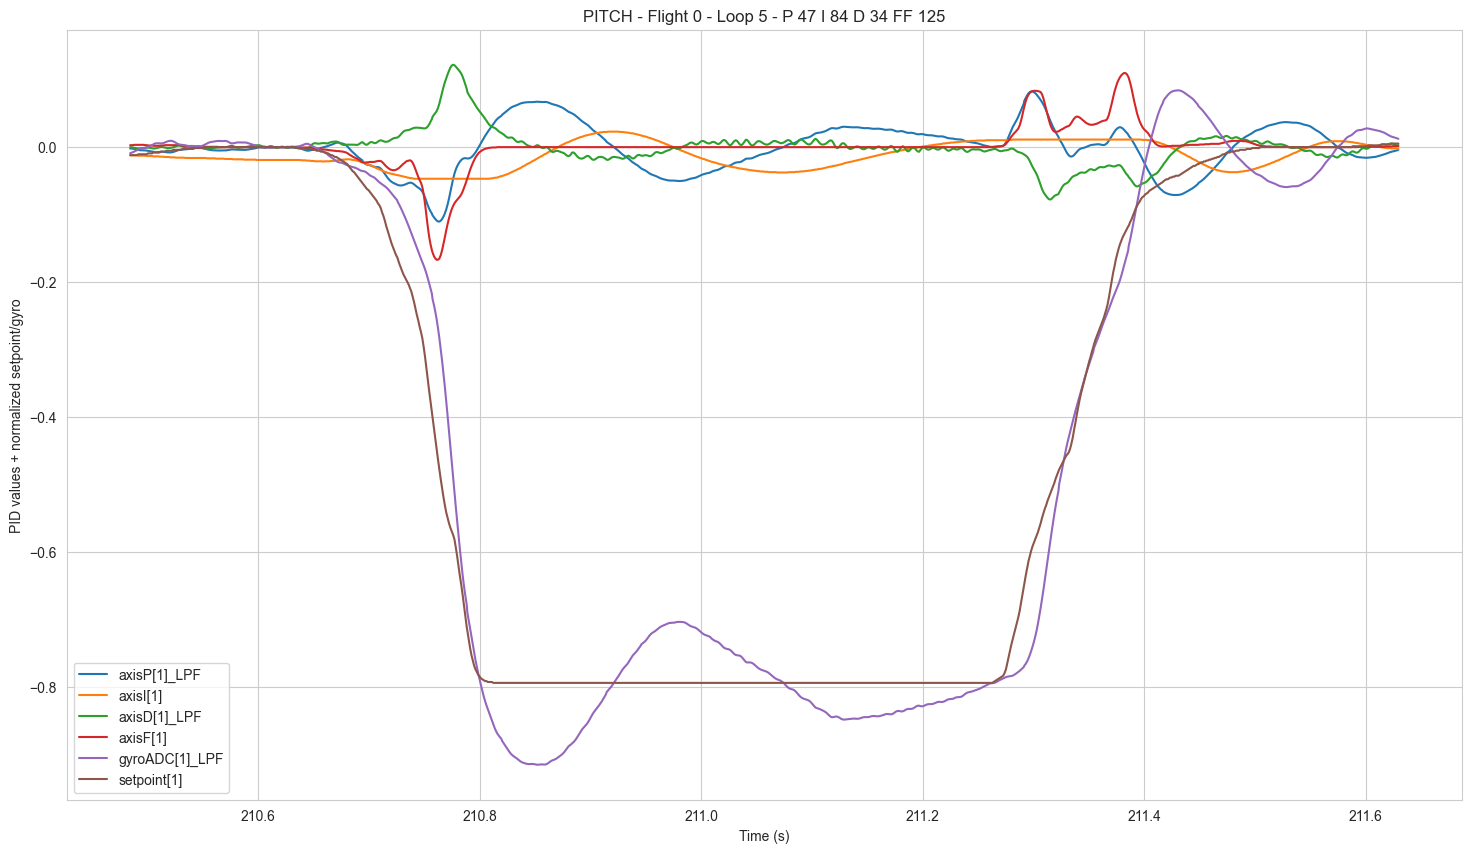

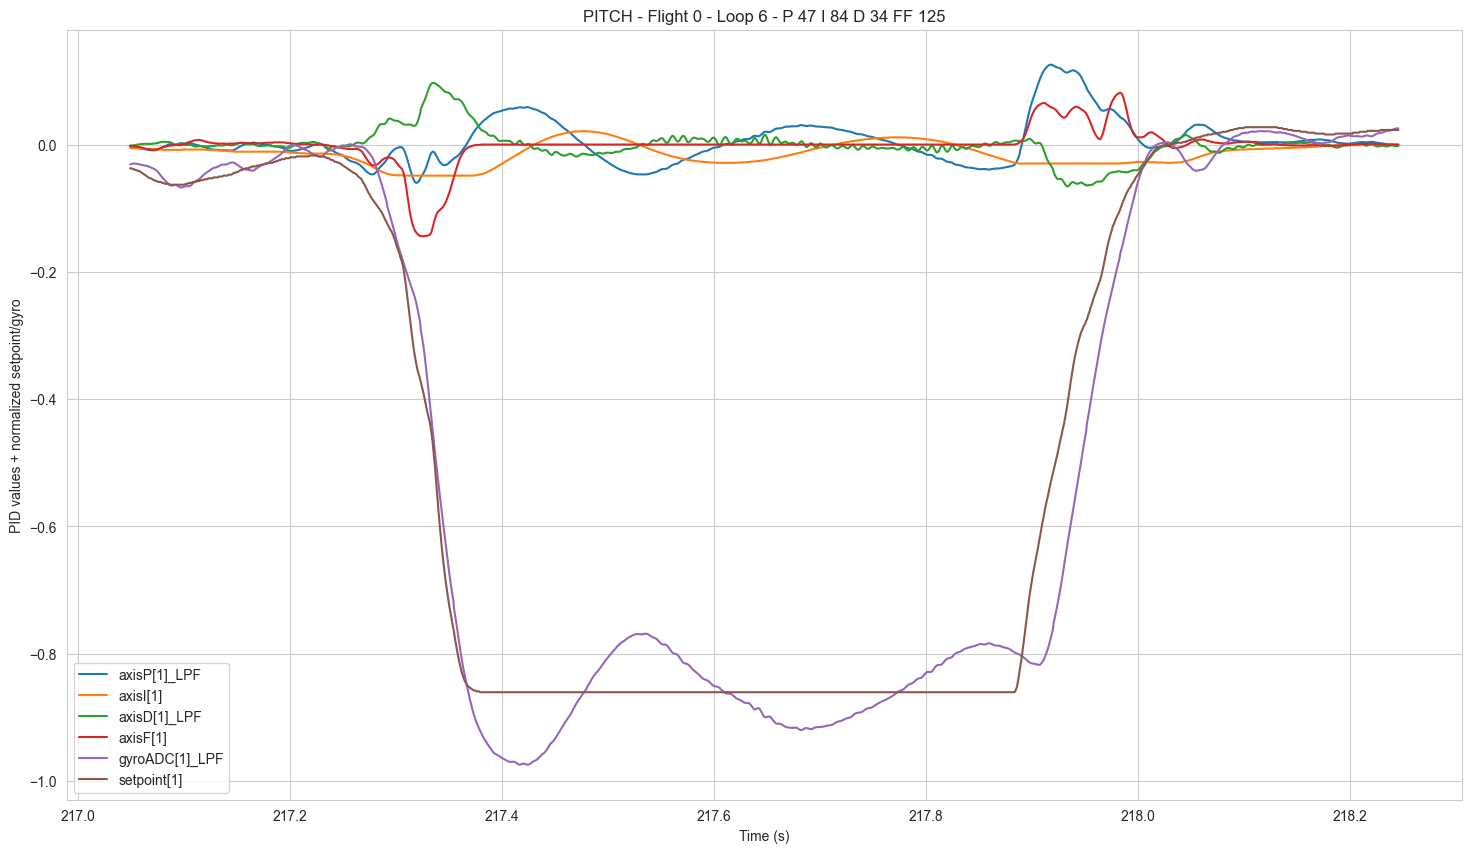

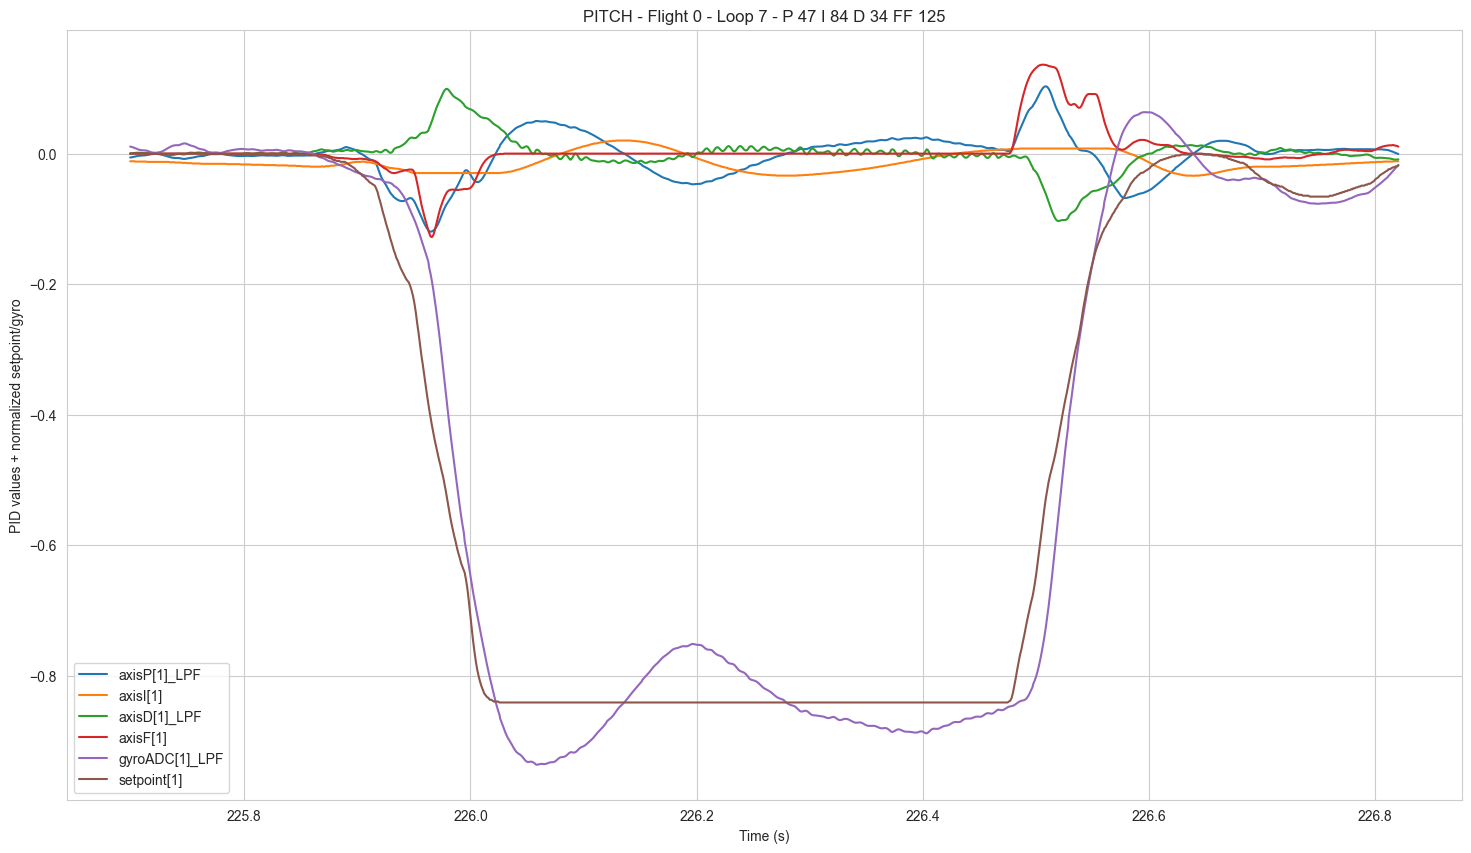

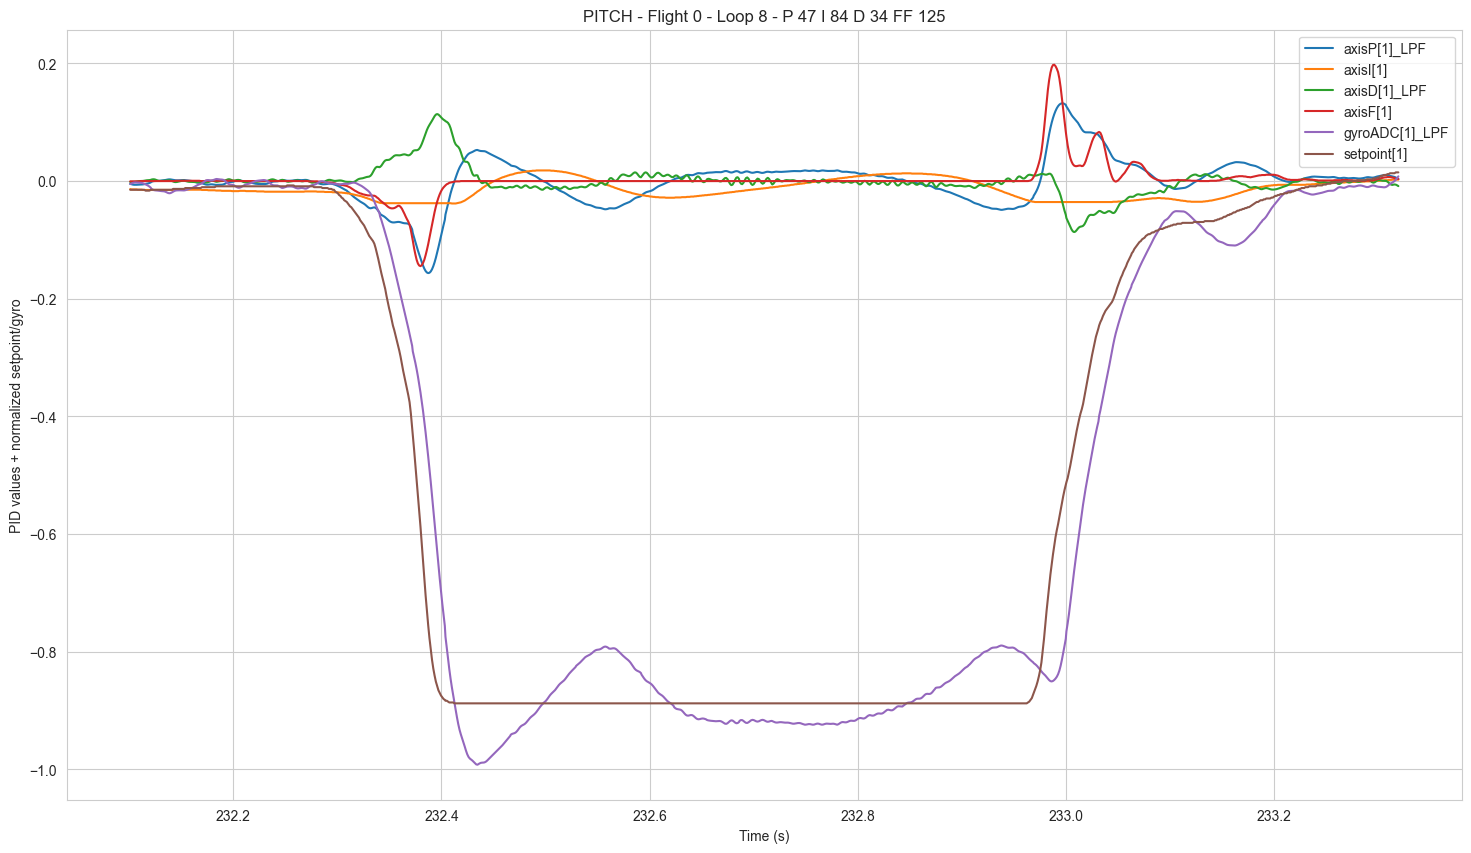

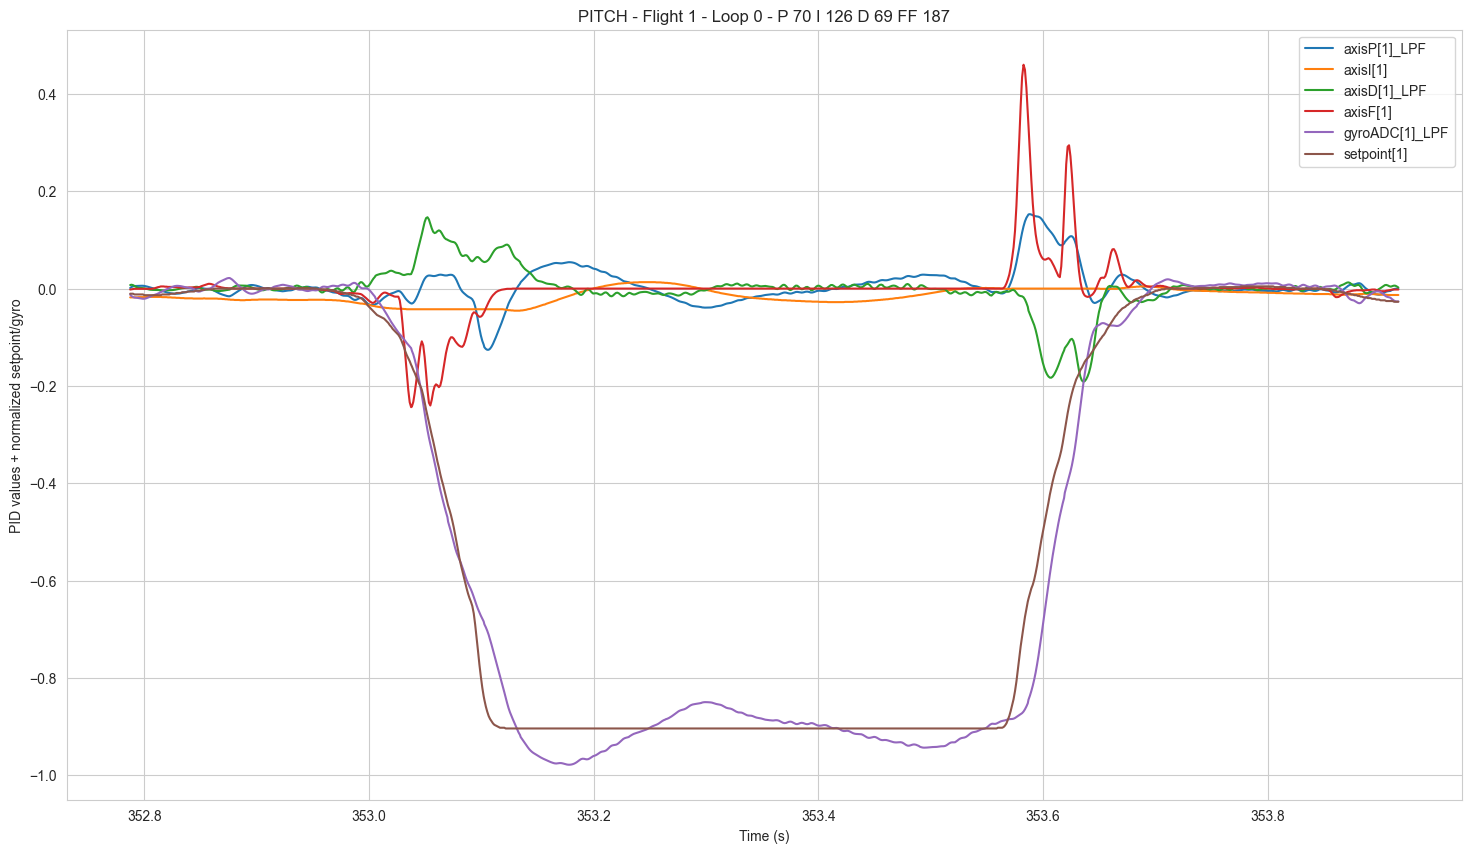

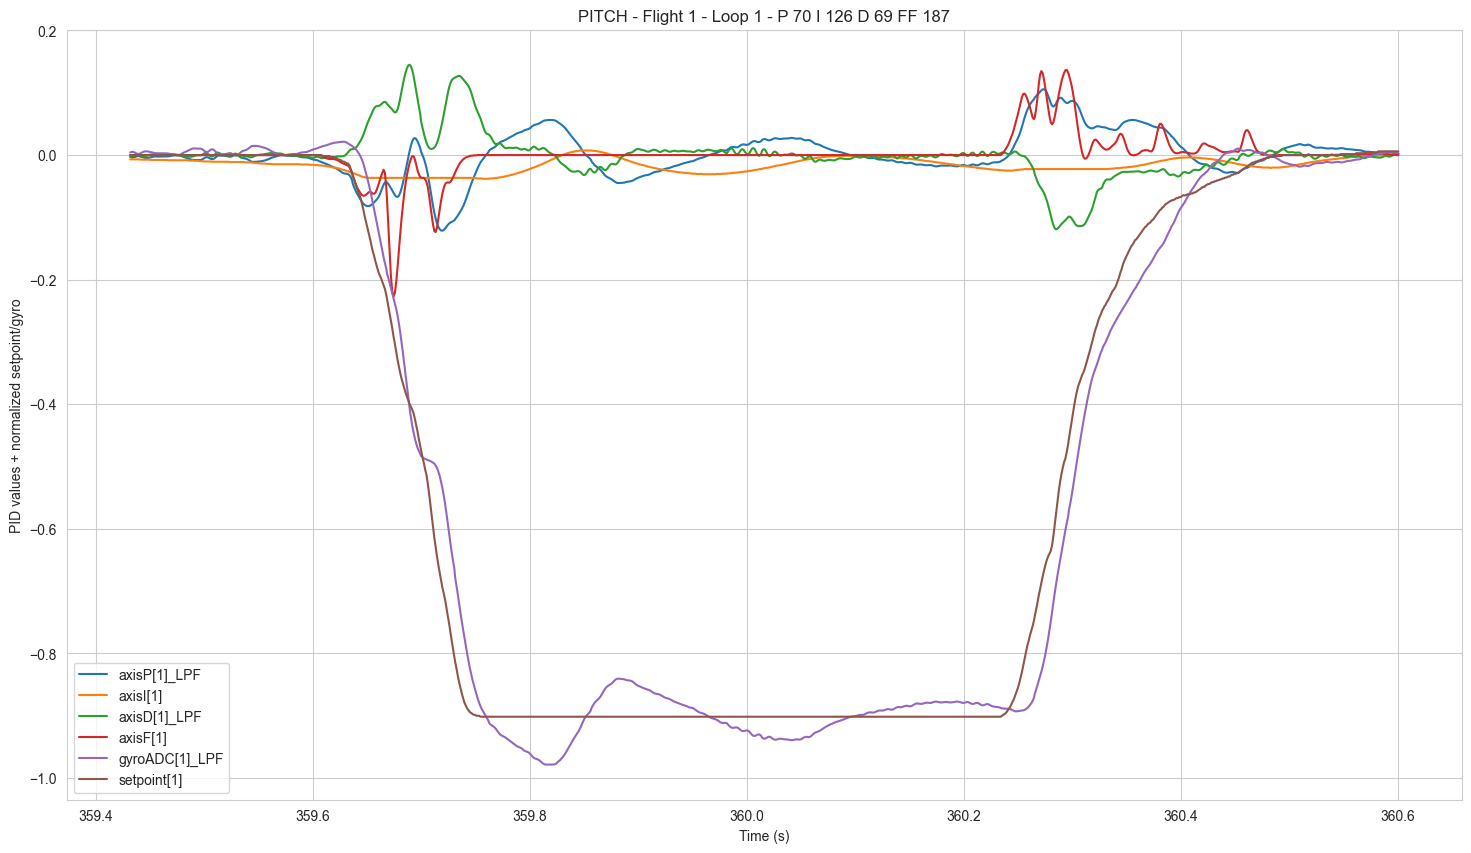

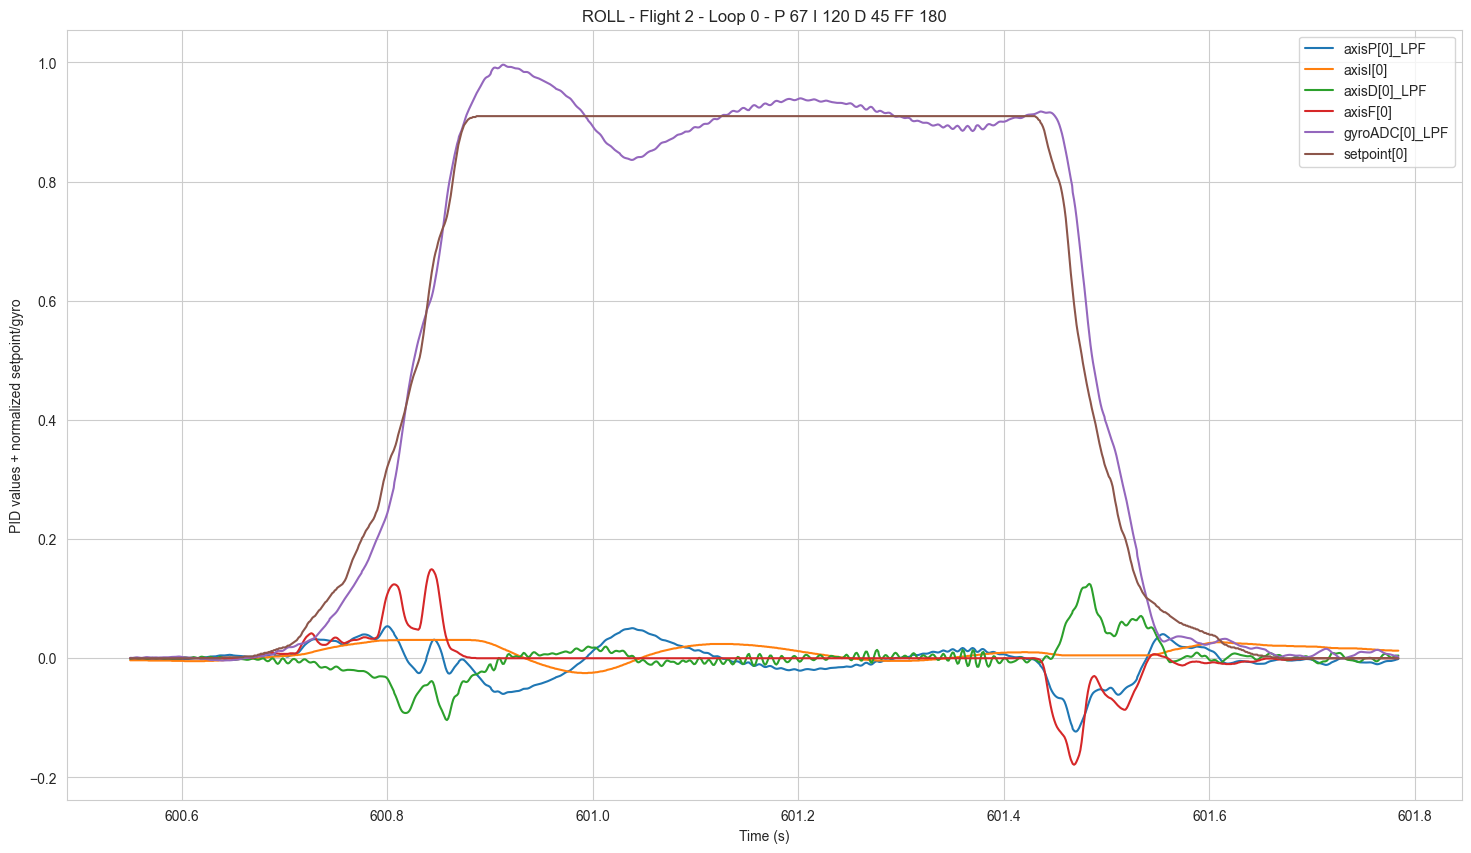

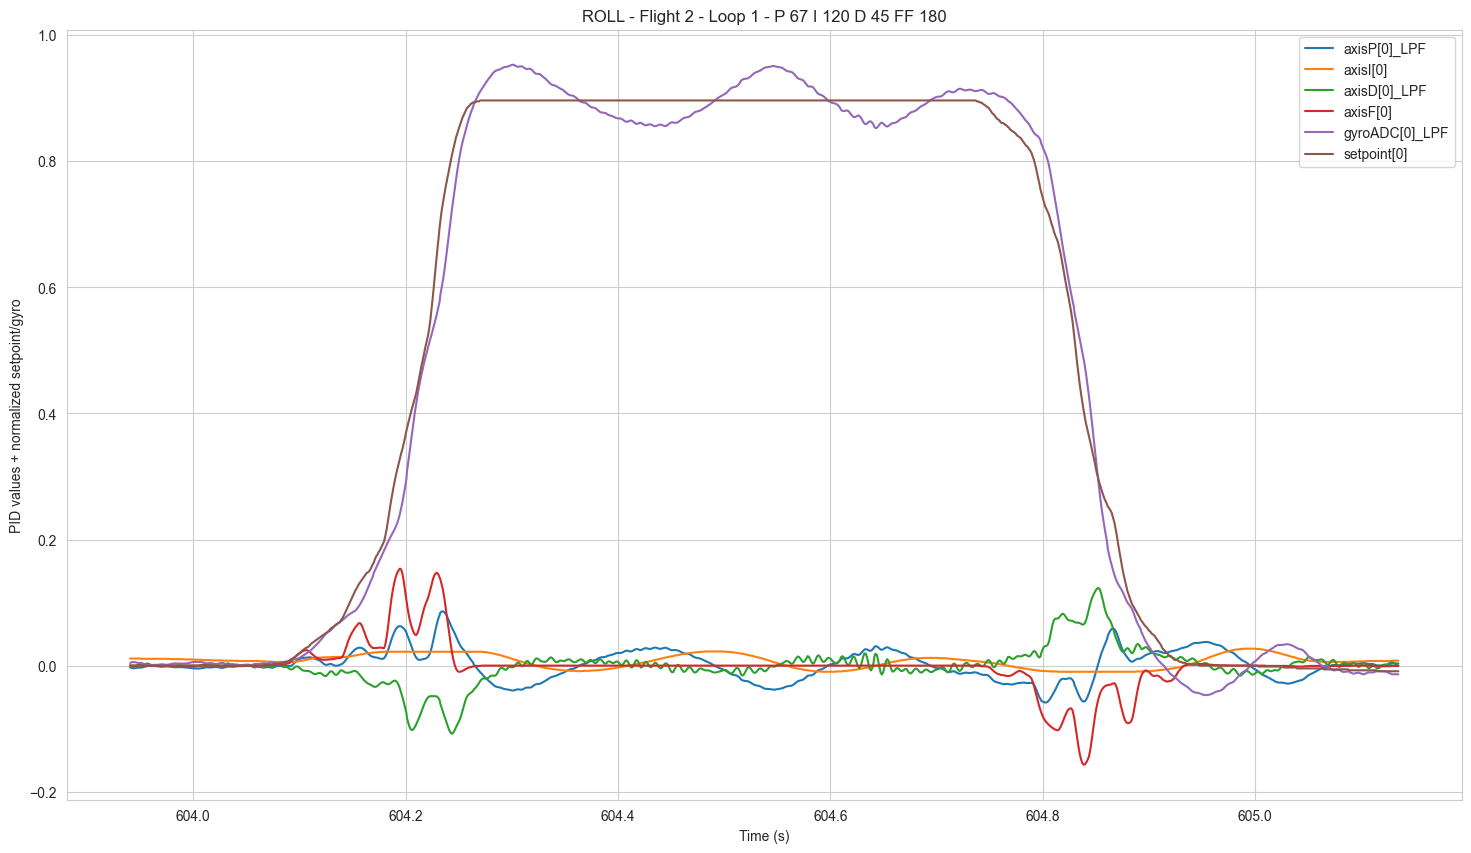

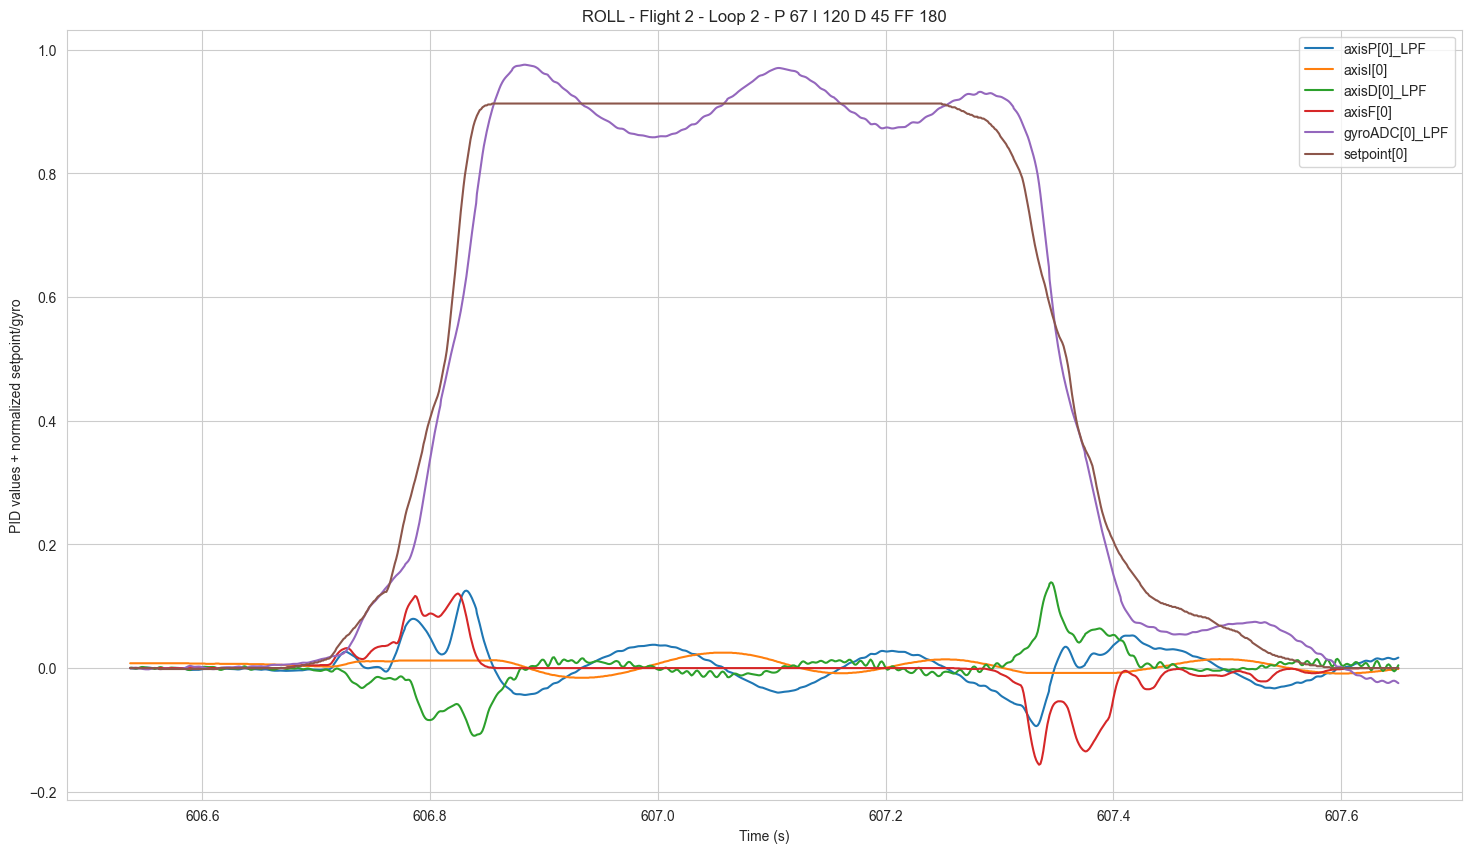

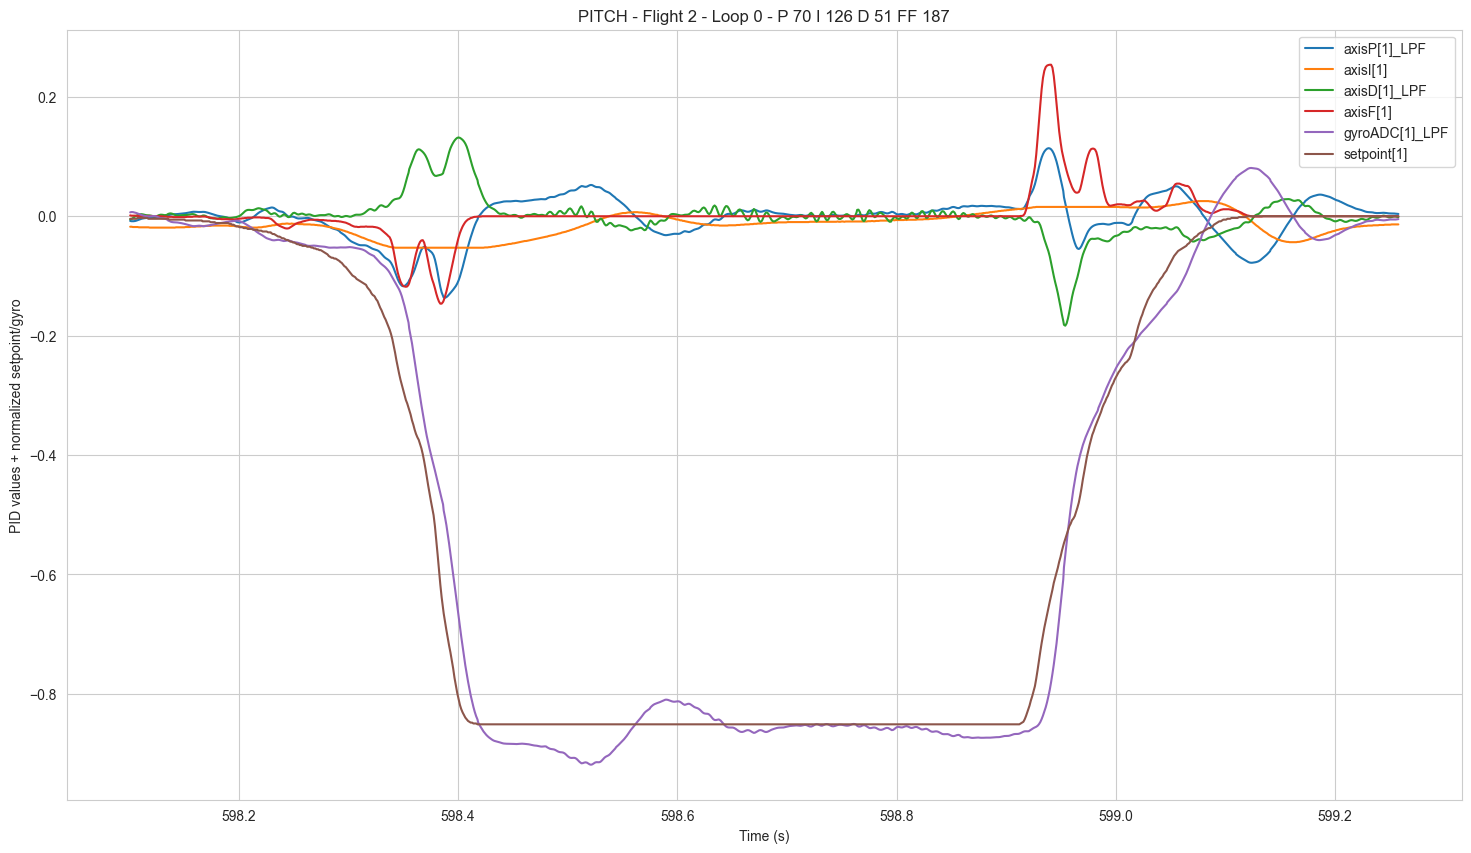

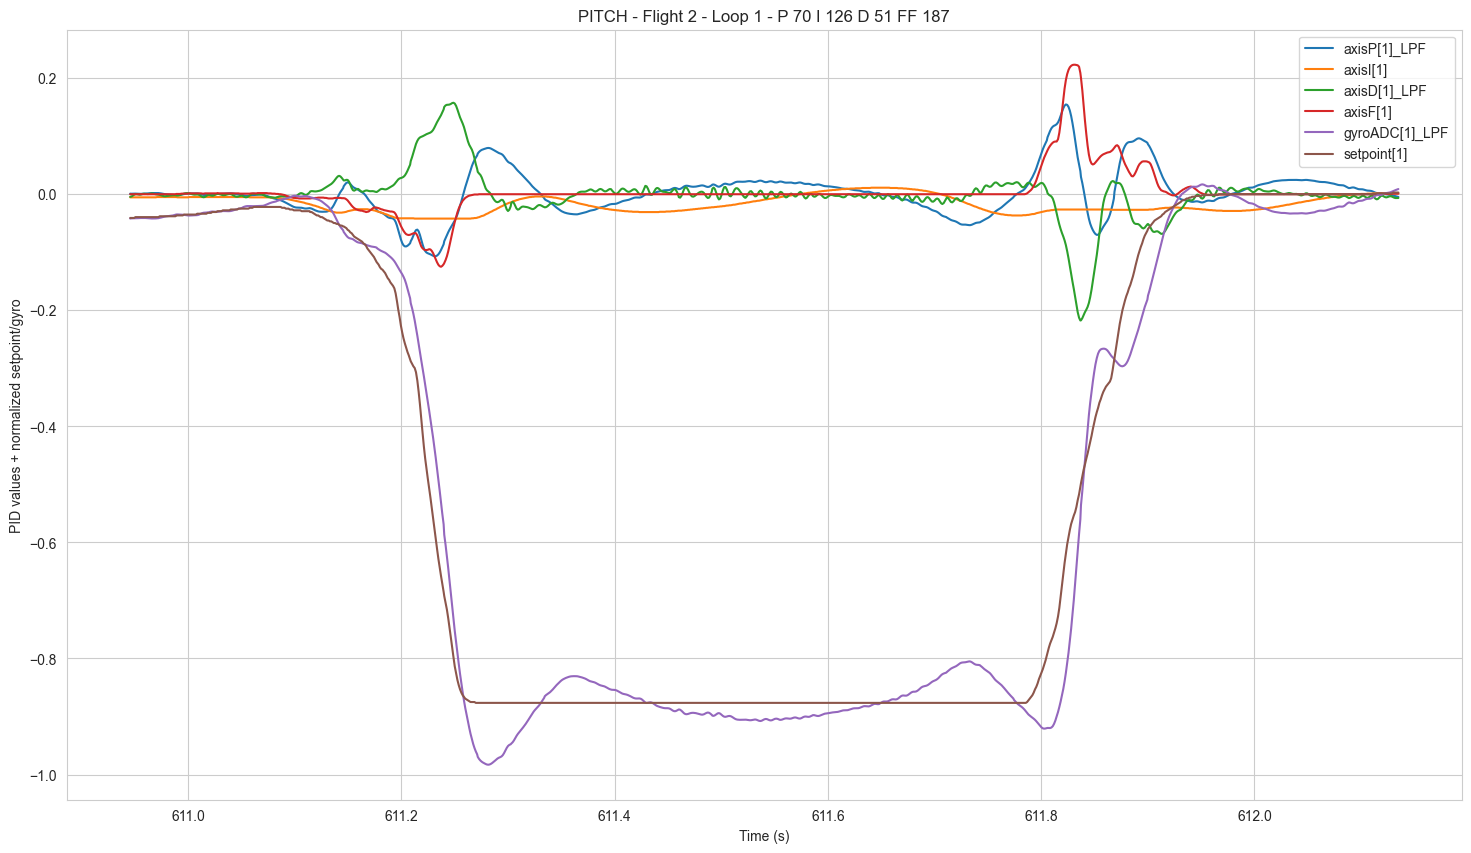

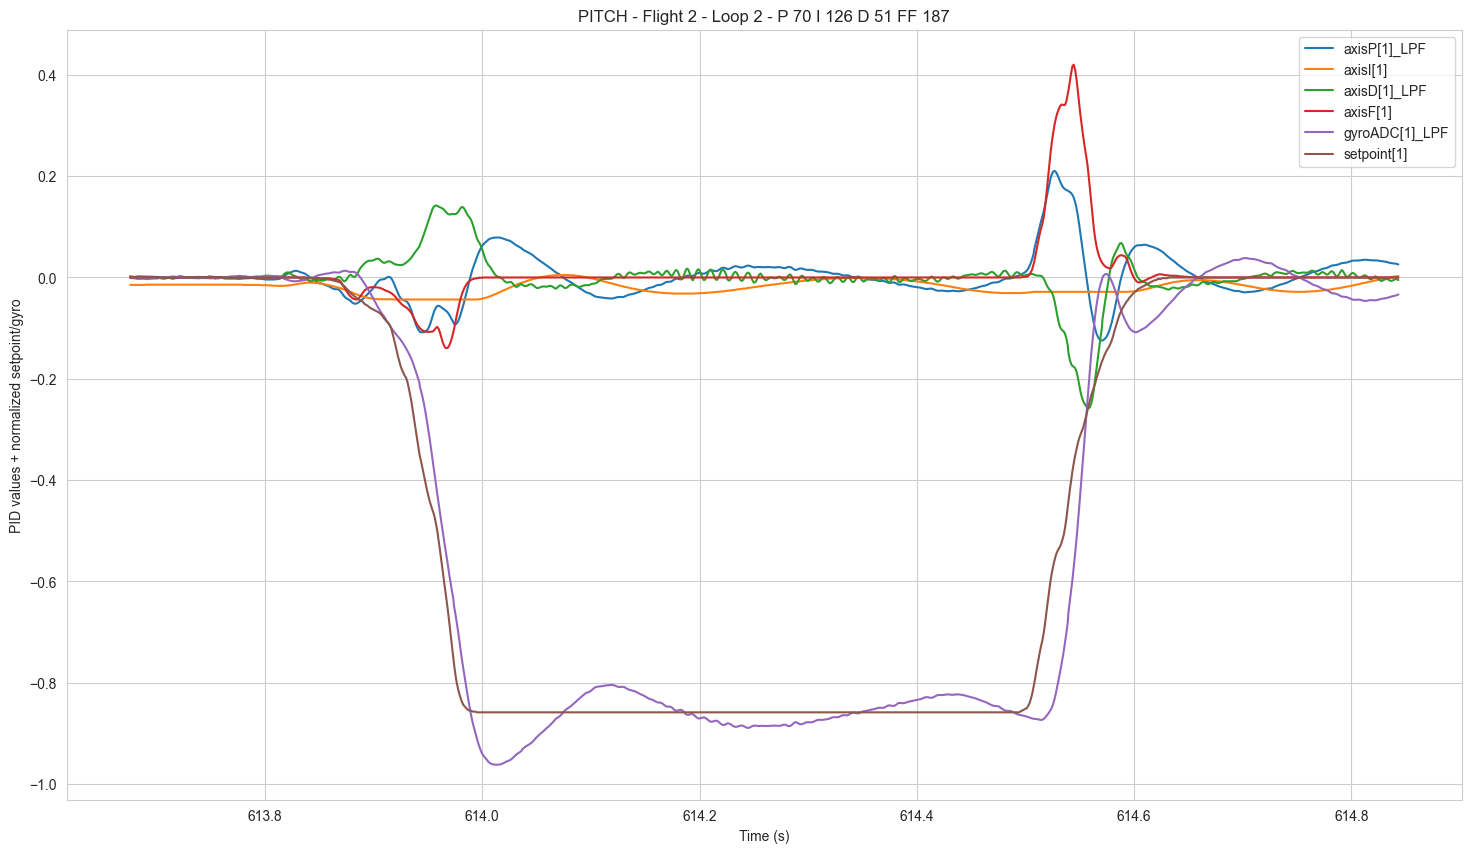

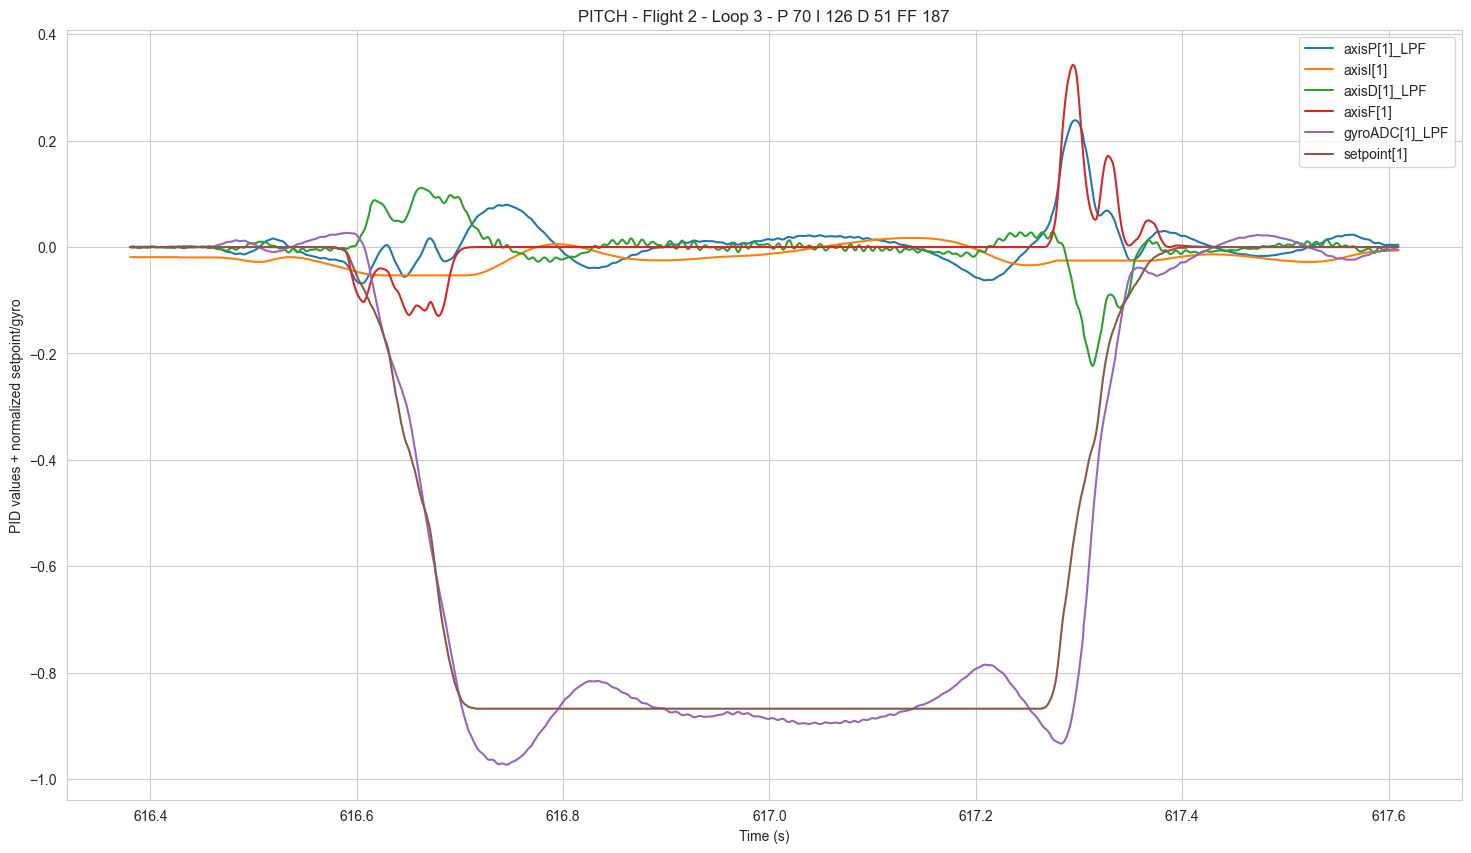

In [3]:
THREASHOLD_UPPER = math.radians(400) # rad/s
THREASHOLD_LOWER = 0.75*THREASHOLD_UPPER
LOOP_EXTRA_TIME = 0.3 # seconds
DISPLAY_WITH_LOW_PASS_FILTER = True

def find_loops(flight, axis):
    y = flight.data[f"gyroADC[{axis}]"].to_numpy()
    high = False

    loops = []
    for idx, x in np.ndenumerate(y):
        if high and abs(x) < THREASHOLD_LOWER:
            high = False
            loops[-1][1] = idx[0]
        elif not high and abs(x) > THREASHOLD_UPPER:
            high = True
            loops.append([idx[0], None])


    for idx, loop in enumerate(loops):
        #print(f"Loop {idx}: {loop}")
        loop[0] -= int(LOOP_EXTRA_TIME*FS)
        loop[1] += int(LOOP_EXTRA_TIME*FS)
        s = np.sum(y[loop[0]:loop[1]])
        s /= FS
        if not abs(s) > math.radians(360-80) or not abs(s) < math.radians(360+80):
            #print("Discard loop")
            continue
        #print(math.degrees(s))
        yield loop

            
def plot_flight_loops(n_flight=0, axis=0):
    flight = flights[n_flight]
    loops = find_loops(flight, axis)
    
    lpf = "_LPF" if DISPLAY_WITH_LOW_PASS_FILTER else ""
    fields_to_plot1 = [
        f"axisP[{axis}]{lpf}",
        f"axisI[{axis}]",
        f"axisD[{axis}]{lpf}",
        f"axisF[{axis}]",
    ]
    fields_to_plot2 = [
        f"gyroADC[{axis}]{lpf}",
        f"setpoint[{axis}]",
    ]
    
    for idx, loop in enumerate(loops):
        i, o = loop

        data = flight.data.iloc[i:o]
        # Normalize Gyro + Setpoint
        df1 = data[fields_to_plot1]
        df2 = data[fields_to_plot2]
        df2_norm = df2/max(df2.max()-df2.min())
        df = pd.concat((df1, df2_norm), axis=1)
                           
        # Plot
        sns.lineplot(data=df, dashes=False, palette="tab10")
        p = flight.pid[axis]["p"]
        i = flight.pid[axis]["i"]
        d = flight.pid[axis]["d"]
        ff = flight.pid[axis]["ff"]
        plt.title(f"{AXIS_LABEL[axis]} - Flight {n_flight} - Loop {idx} - P {p} I {i} D {d} FF {ff}")
        plt.xlabel("Time (s)")
        plt.ylabel("PID values + normalized setpoint/gyro")
        plt.show()
        
for i in range(len(flights)):
    for axis in range(3):
        plot_flight_loops(i, axis=axis)


# Step Response

Try to compute the step response for each axis. The Blackbox data needs to have a lot of full stick flip and rolls to get accurate data from this step.

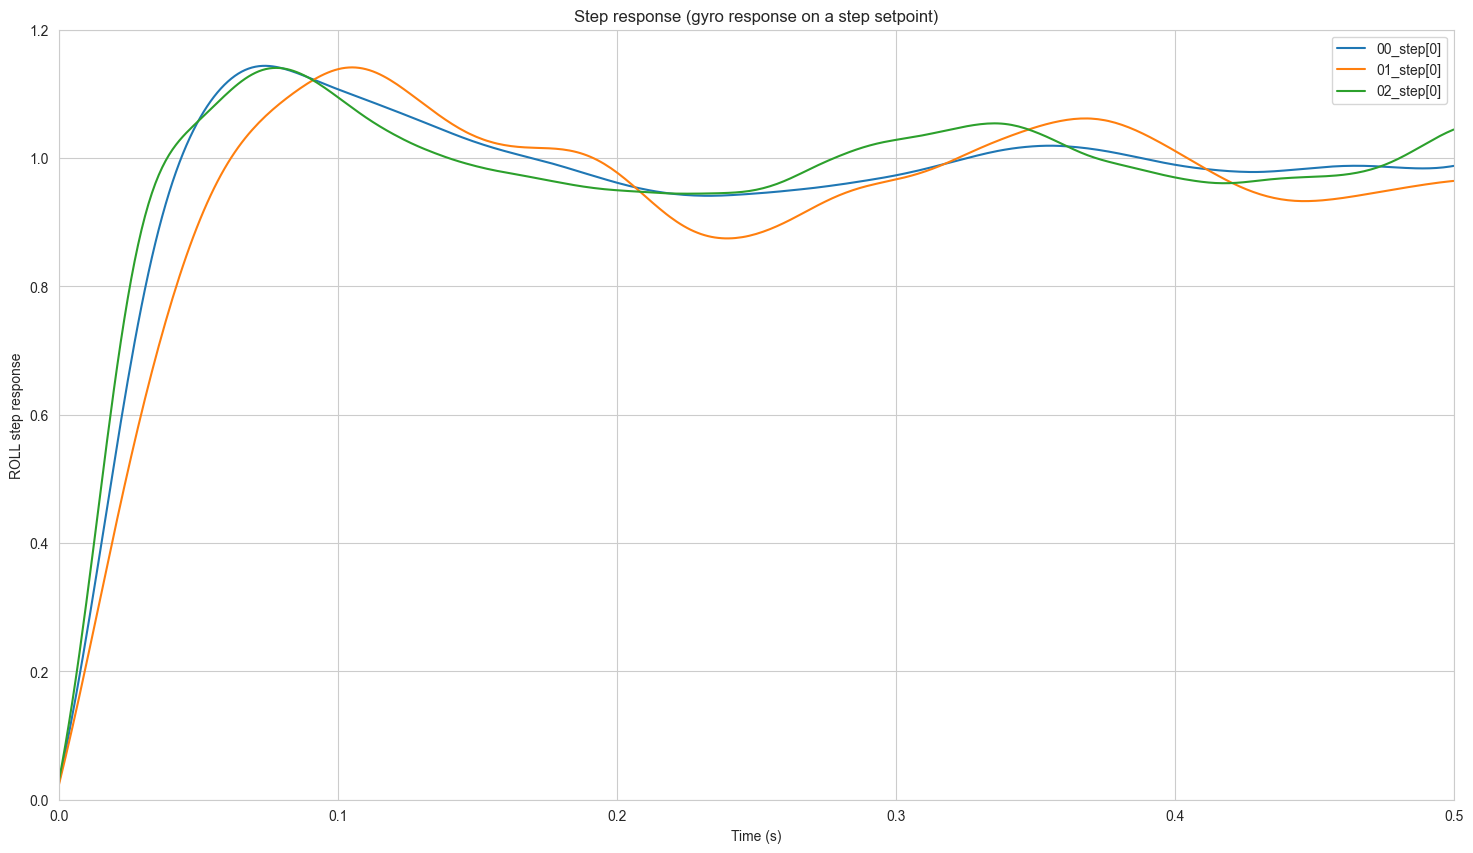

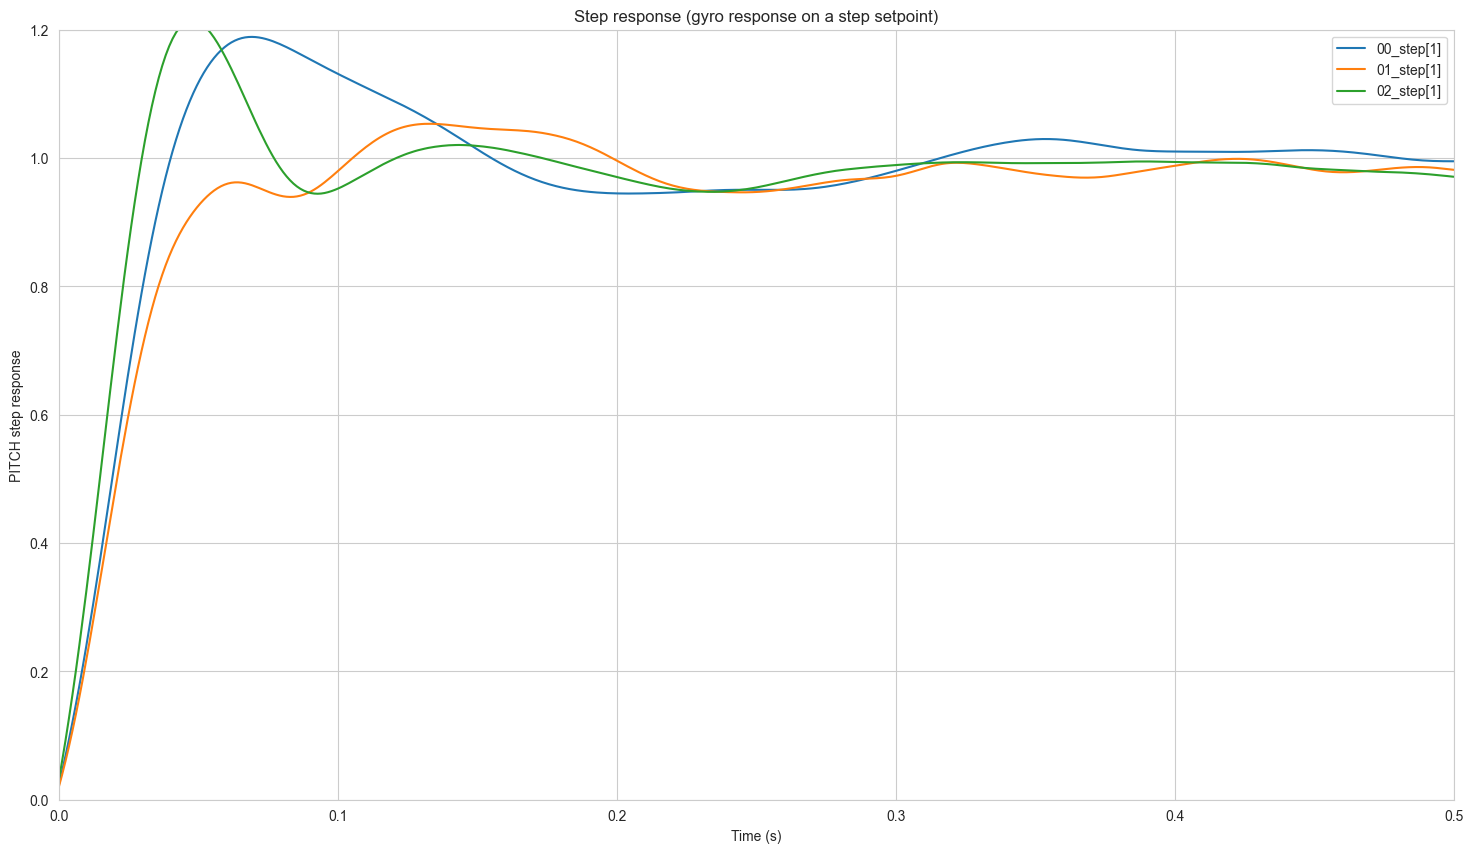

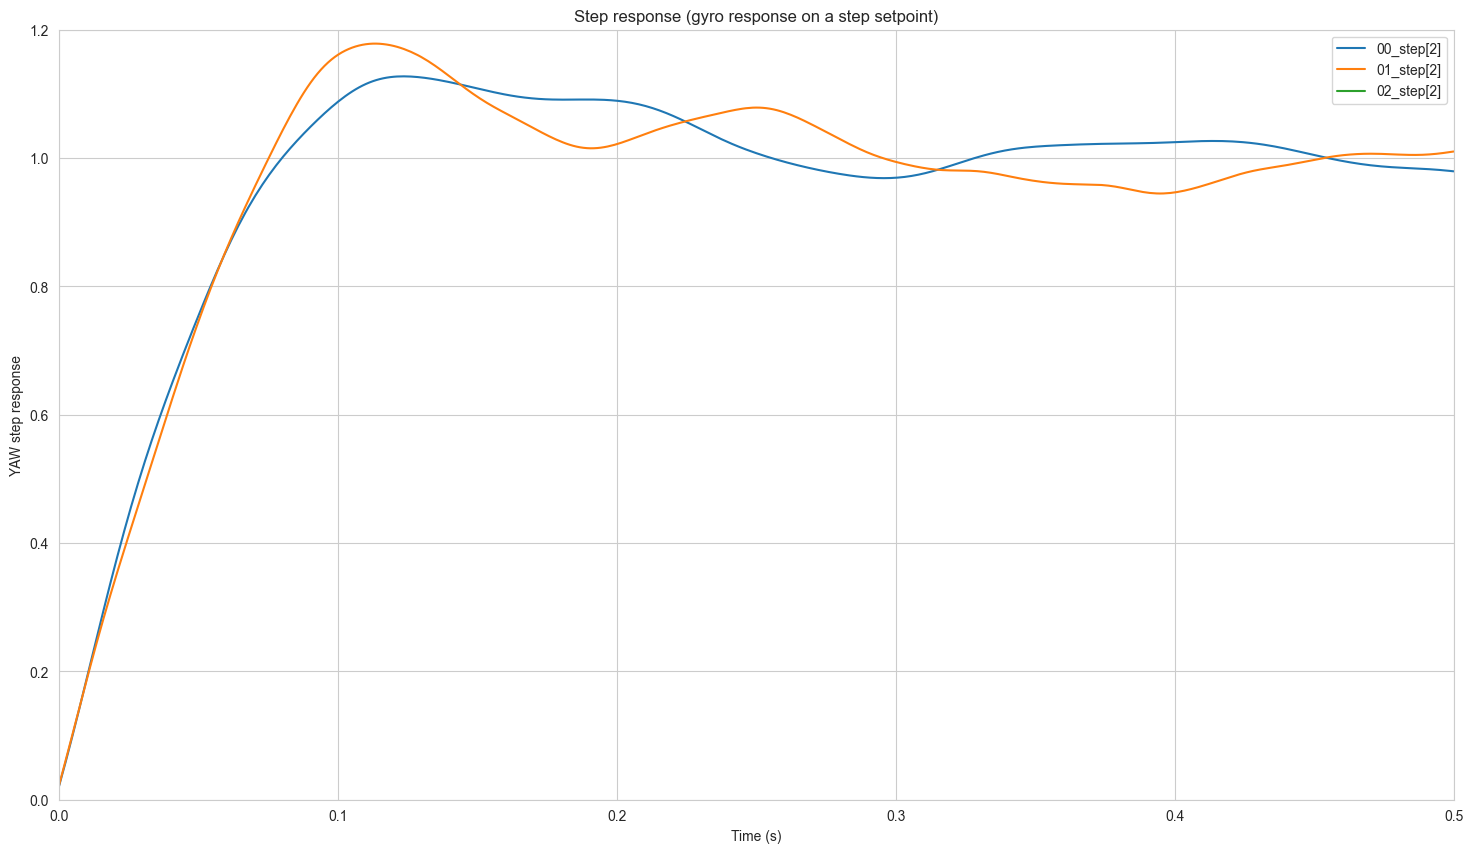

In [4]:
def compute_step_response(df):
    def PTstepcalc(SP, GY):
        """Translated from MATLAB from PIDtoolbox: https://github.com/bw1129/PIDtoolbox"""
        minInput = 0.34 # rad/s
        segment_length = int(FS*2) # 2 sec segments
        step_duration = .5 # second        
        step_samples = int(FS * step_duration) # 500ms step response function, length will depend on lograte  
        t = np.linspace(0, step_duration, step_samples)

        fileDurSec = len(SP) / FS
        subsampleFactor = 10

        segment_vector = np.arange(1, len(SP), round(segment_length/subsampleFactor))
        NSegs = len(segment_vector)

        stepresponse = []
        if NSegs > 0:
            SPseg = []
            GYseg = []
            j = 0
            for i in range(NSegs-1):
                if np.max(np.abs(SP[segment_vector[i]:segment_vector[i]+segment_length])) >= minInput:
                    j=j+1
                    SPseg.append(SP[segment_vector[i]:segment_vector[i]+segment_length])  
                    GYseg.append(GY[segment_vector[i]:segment_vector[i]+segment_length]) 

            SPseg = np.array(SPseg, dtype=object)
            GYseg = np.array(GYseg, dtype=object)

            j=0 
            if len(SPseg) > 0:
                for i in range(len(SPseg)):
                    a = GYseg[i]*np.hanning(len(GYseg[i]))                
                    b = SPseg[i]*np.hanning(len(SPseg[i]))
                    a = np.fft.fft(a)
                    b = np.fft.fft(b)
                    G = a / len(a)
                    H = b / len(b) 
                    Hcon = np.conj(H)  

                    imp = np.real(np.fft.ifft((G * Hcon) / (H * Hcon + 0.0001 )))
                    resptmp = np.cumsum(imp) # integrate impulse resp function 

                    steadyStatePoints = resptmp[50:]
                    steadyStateMean = np.mean(steadyStatePoints)

                    resptmp = resptmp / steadyStateMean

                    if np.min(steadyStatePoints) < 0.50 or max(steadyStatePoints) > 3: # Quality control
                        continue
                    j=j+1
                    stepresponse.append(resptmp[:step_samples])

        return t, np.mean(stepresponse, axis=0) if stepresponse else None

    t, stepresponse_x = PTstepcalc(df['setpoint[0]'].to_numpy(), df['gyroADC[0]'].to_numpy())
    t, stepresponse_y = PTstepcalc(df['setpoint[1]'].to_numpy(), df['gyroADC[1]'].to_numpy())
    t, stepresponse_z = PTstepcalc(df['setpoint[2]'].to_numpy(), df['gyroADC[2]'].to_numpy())

    return pd.DataFrame({
        'step[0]': stepresponse_x,
        'step[1]': stepresponse_y,
        'step[2]': stepresponse_z,
    }, t)

def plot_step_response(data, axis=0):
    columns = [c for c in data.columns if c.endswith(AXIS[axis])]
    if not columns: # no PID D on YAW
        return

    sns.lineplot(data=data[columns], dashes=False, palette="tab10")
    plt.title('Step response (gyro response on a step setpoint)')
    plt.ylim([0, 1.2])
    plt.xlim([0, .5])
    plt.xlabel('Time (s)')
    plt.ylabel(f"{AXIS_LABEL[axis]} step response")

def compute_step_responses(flights):
    step_responses = []
    for i, flight in enumerate(flights):
        data = compute_step_response(flight.data)
        rename = {name: f"{flight.number:02d}_{name}" for name in data.columns}
        data = data.rename(columns=rename)
        step_responses.append(data)

    return pd.concat(step_responses, axis=1)
    
step_responses = compute_step_responses(flights)
plot_step_response(step_responses, axis=0)
plt.show()
plot_step_response(step_responses, axis=1)
plt.show()
plot_step_response(step_responses, axis=2)
plt.show()
